## Get a simple data set object together

In [1]:
import tensorflow as tf
from keras.layers import Conv2D, LeakyReLU, Input, MaxPooling2D, Activation, Conv2DTranspose, Concatenate, Dropout
from keras.models import Model, Sequential
import keras
import matplotlib.pyplot as plt

In [2]:
#Make the dataset
from cycleganstyletransfer.config import DATA_DIR
data_dir = DATA_DIR / "raw"


my_monet_ds_train, my_monet_ds_val = tf.keras.utils.image_dataset_from_directory(
    data_dir / "Monet",
    validation_split=0.1,
    subset="both",
    seed=42,
    image_size=(128, 128),
    batch_size = 1,
    labels = None,
)

my_image_ds_train, my_image_ds_val = tf.keras.utils.image_dataset_from_directory(
    data_dir / "Images",
    validation_split=0.1,
    subset="both",
    seed=42,
    image_size=(128, 128),
    batch_size = 1,
    labels = None,
)

#my_monet_ds_train = my_monet_ds_train.map(lambda x: (x / 127.5) - 1)
#my_image_ds_train = my_image_ds_train.map(lambda x: (x / 127.5) - 1)
    
DATASET_HEIGHT = max(len(my_monet_ds_train), len(my_image_ds_train))

my_monet_ds_train = iter(my_monet_ds_train.shuffle(42).repeat())
my_image_ds_train = iter(my_image_ds_train.shuffle(42).repeat())

2025-06-10 14:31:49.050 | INFO     | cycleganstyletransfer.config:<module>:11 - PROJ_ROOT path is: C:\Users\willi\Desktop\AIPortfolio\CycleGanV2\cycleganstyletransfer


Found 1193 files belonging to 1 classes.
Using 1074 files for training.
Using 119 files for validation.
Found 7037 files belonging to 1 classes.
Using 6334 files for training.
Using 703 files for validation.


## Put the Discrim model together (With regularization)

In [3]:
def build_discriminator(input_shape=(128, 128, 3)):
    inputs = Input(shape=input_shape)
    
    # First layer doesn't use instance normalization
    x = Conv2D(16, 3,padding='same')(inputs)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.3)(x)
    x = MaxPooling2D(2)(x)

    x = Conv2D(32, 3,padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.3)(x)
    x = MaxPooling2D(2)(x)

    x = Conv2D(64, 3,padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.3)(x)
    x = MaxPooling2D(2)(x)

    x = Conv2D(1, 3, padding='same')(x)
    
    return Model(inputs, x, name='discriminator')

my_discriminator = build_discriminator()
my_discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 16)      0         
                                                                 
 dropout (Dropout)           (None, 128, 128, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                     

## Generator model

In [4]:
class InstanceNormalization(keras.layers.Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        # One scale and bias per channel
        self.gamma = self.add_weight(
            shape=(input_shape[-1],),
            initializer='ones',
            trainable=True,
            name='gamma'
        )
        self.beta = self.add_weight(
            shape=(input_shape[-1],),
            initializer='zeros',
            trainable=True,
            name='beta'
        )
        super(InstanceNormalization, self).build(input_shape)

    def call(self, inputs):
        # Compute mean and variance per instance, per channel
        mean, variance = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
        normalized = (inputs - mean) / tf.sqrt(variance + self.epsilon)
        return self.gamma * normalized + self.beta

    def get_config(self):
        config = super().get_config().copy()
        config.update({"epsilon": self.epsilon})
        return config


In [5]:
def DownSampleBlock(filters:int, kernel_size:int, strides:int):
    ret_block = Sequential()
    ret_block.add(Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same'))
    ret_block.add(InstanceNormalization())
    ret_block.add(Activation('relu'))
    return ret_block


In [9]:
from keras.layers import UpSampling2D, Conv2D
import uuid

def UpSampleBlock(filters: int, kernel_size: int, strides: int):
    ret_block = Sequential(name=f'UpsampleBlock_{uuid.uuid4()}')
    ret_block.add(UpSampling2D(size=(strides, strides)))  # replaces strided transpose
    ret_block.add(Conv2D(filters=filters, kernel_size=kernel_size, padding='same'))
    ret_block.add(InstanceNormalization())
    ret_block.add(Activation('relu'))
    return ret_block


In [10]:

def Generator(input_shape:tuple, kernel_size:int=3, strides:int=1
              ,filter_line:list[int]=[32,64,128]) -> keras.Model:
    networks_appending = []
    input_block = Input(shape=input_shape)
    ret_block = input_block

    #Create encoder chain
    for filter_choice in filter_line:
        ret_block=DownSampleBlock(filter_choice,3,2)(ret_block)
        networks_appending.append(ret_block)

    #Decoder with residual connections
    for filter_choice, network_append in zip(filter_line[::-1][1:], networks_appending[::-1][1:]):
        ret_block = UpSampleBlock(filter_choice, 3,2)(ret_block)
        ret_block = Concatenate()([ret_block, network_append])
    
    ret_block = Conv2DTranspose(input_shape[-1], kernel_size, strides, padding='same', activation='tanh')(ret_block)

    return Model(input_block, ret_block)



In [11]:
my_generator = Generator((128, 128, 3), strides=2)
my_generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 sequential_3 (Sequential)   (None, 64, 64, 32)           960       ['input_3[0][0]']             
                                                                                                  
 sequential_4 (Sequential)   (None, 32, 32, 64)           18624     ['sequential_3[0][0]']        
                                                                                                  
 sequential_5 (Sequential)   (None, 16, 16, 128)          74112     ['sequential_4[0][0]']        
                                                                                              

In [12]:
def my_square_loss(y_true, y_pred):
    y_true = tf.reshape(tf.cast(y_true, tf.float32), (-1, 1, 1, 1))
    y_true = tf.broadcast_to(y_true, tf.shape(y_pred))
    return tf.reduce_mean(tf.math.squared_difference(y_true, y_pred))


## Introducing Generator loss

In [13]:
def generator_loss(descrim_output):
        return tf.reduce_mean(tf.math.squared_difference(tf.ones_like(descrim_output), descrim_output))

## Adding Alternating trainin

In [14]:
def augment_and_normalize(image):
    image = tf.cast(image, tf.float32)  # convert from uint8
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=20)  # for 0–255 range
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    image = image / 127.5 - 1.0  # scale to [-1, 1]
    return image


In [15]:
def to_display(img):
    return tf.clip_by_value(img * 0.5 + 0.5, 0.0, 1.0)



Epoch 1/2


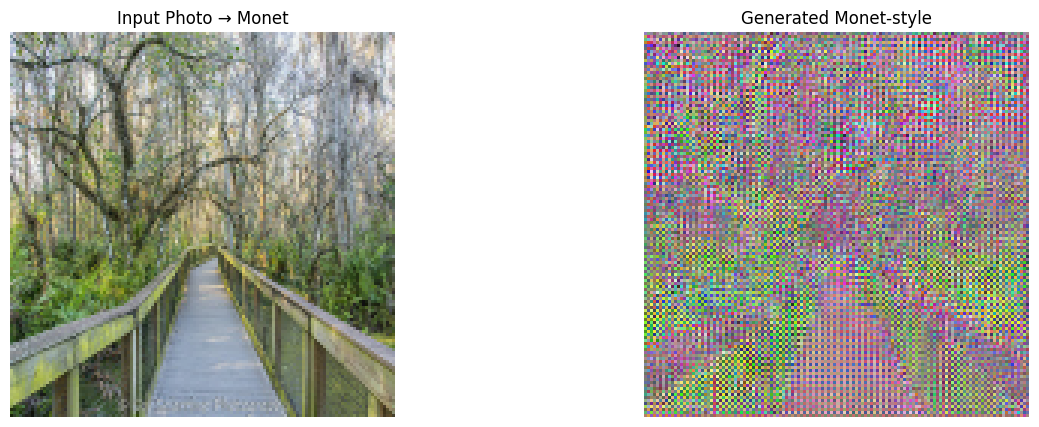

Step 91/1266 - M-disc: 0.1503, P-disc: 0.2942, M-gen: 0.4051, P-gen: 0.4794, Cycle: 0.8619, Identity: 0.9300

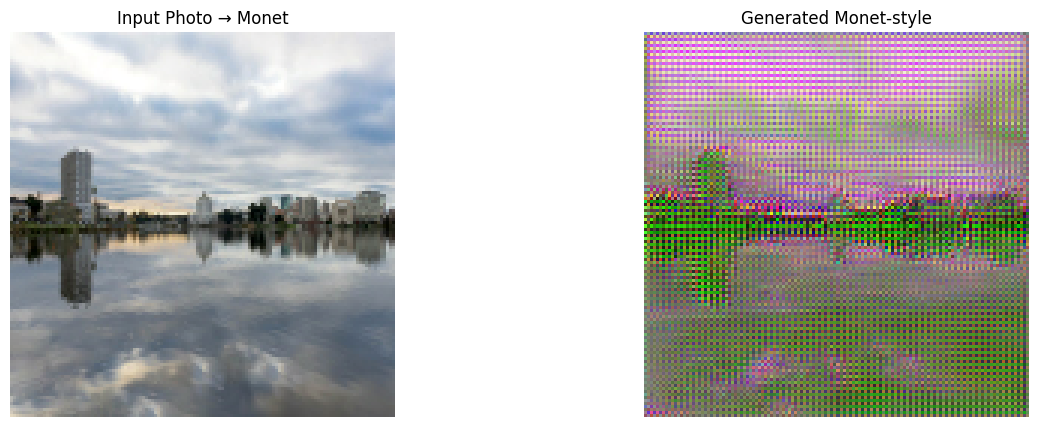

Step 196/1266 - M-disc: 0.2309, P-disc: 0.2556, M-gen: 0.4923, P-gen: 0.4251, Cycle: 0.5144, Identity: 0.5375

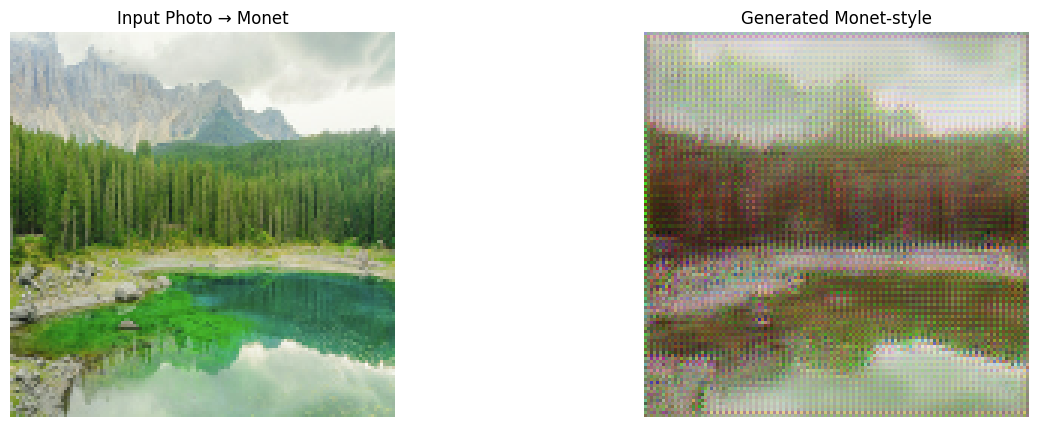

Step 286/1266 - M-disc: 0.2011, P-disc: 0.1574, M-gen: 0.2551, P-gen: 0.5632, Cycle: 0.6606, Identity: 0.7200

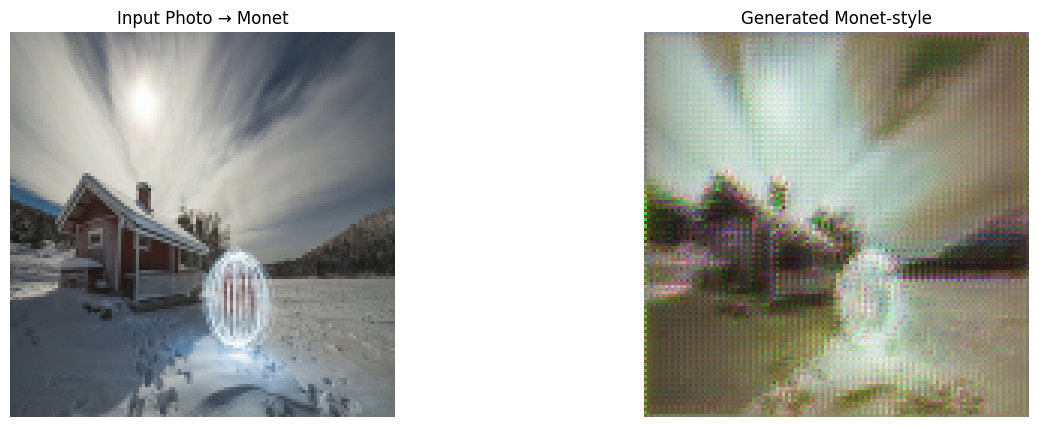

Step 391/1266 - M-disc: 0.0711, P-disc: 0.1578, M-gen: 0.5646, P-gen: 0.3010, Cycle: 0.8563, Identity: 1.0179

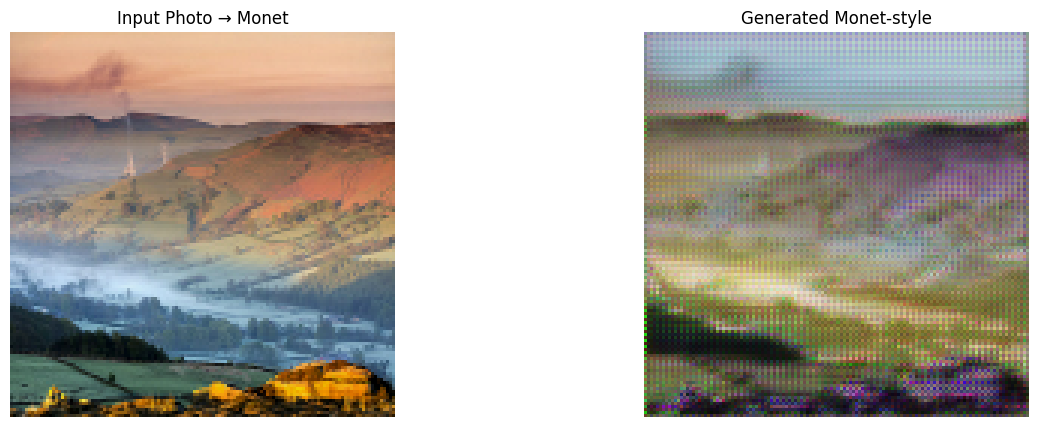

Step 496/1266 - M-disc: 0.2647, P-disc: 0.1631, M-gen: 0.3601, P-gen: 0.3649, Cycle: 0.4991, Identity: 0.5898

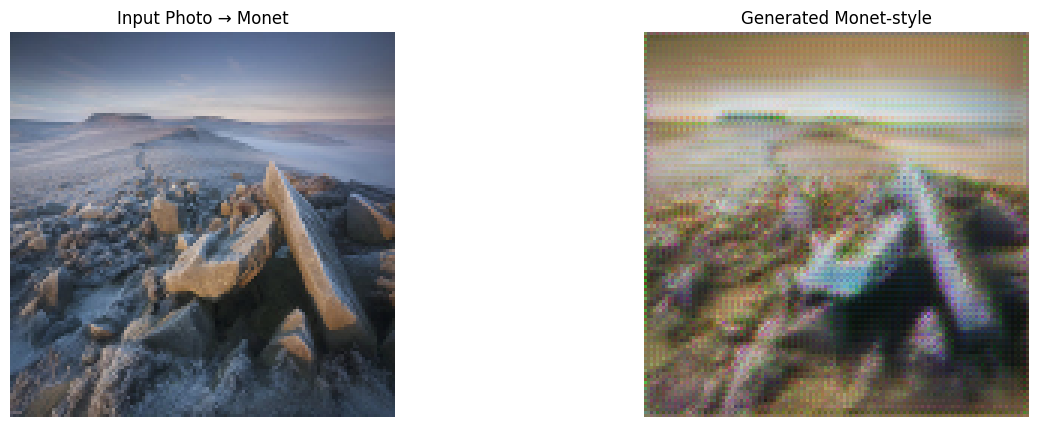

Step 586/1266 - M-disc: 0.2861, P-disc: 0.2741, M-gen: 0.3605, P-gen: 0.3949, Cycle: 0.5307, Identity: 0.5476

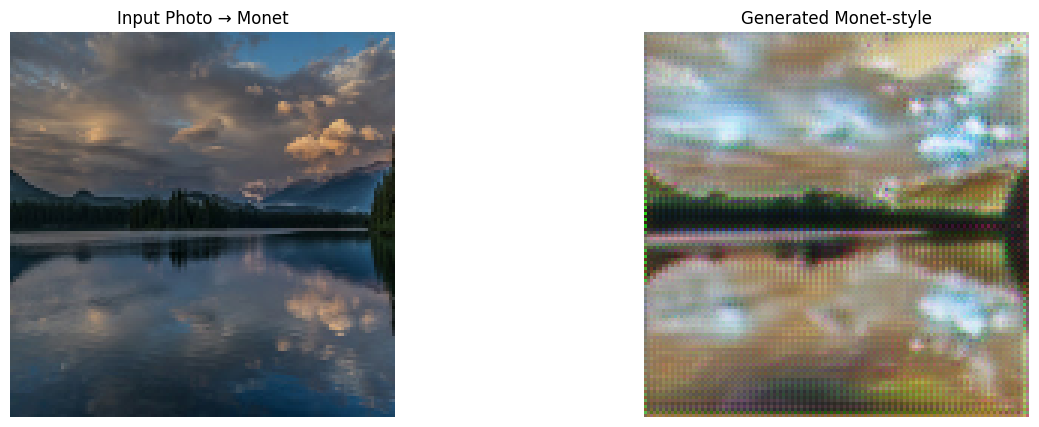

Step 691/1266 - M-disc: 0.1883, P-disc: 0.2057, M-gen: 0.3081, P-gen: 0.2995, Cycle: 0.5665, Identity: 0.5889

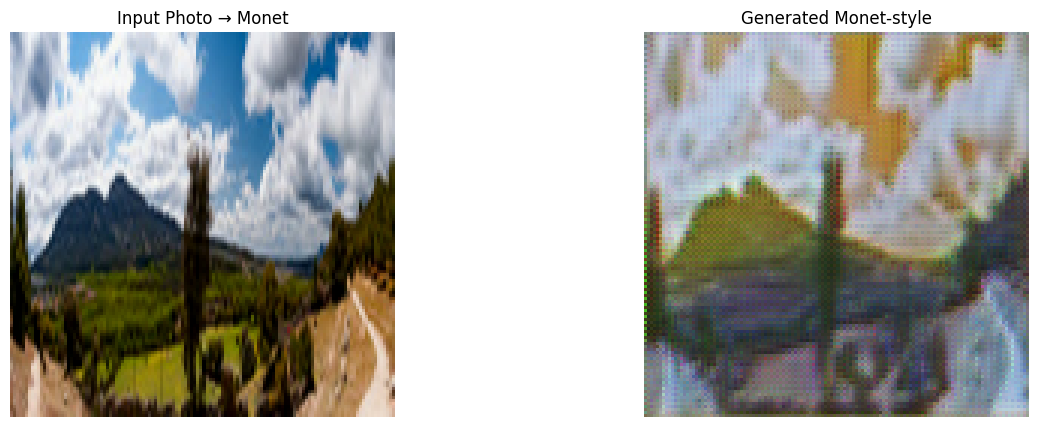

Step 796/1266 - M-disc: 0.2284, P-disc: 0.2864, M-gen: 0.2772, P-gen: 0.3380, Cycle: 0.4937, Identity: 0.5268

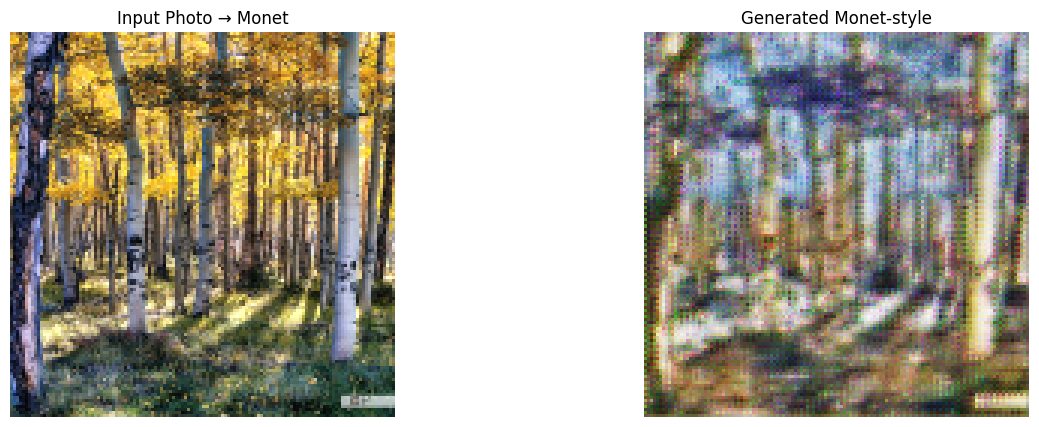

Step 886/1266 - M-disc: 0.1262, P-disc: 0.3184, M-gen: 0.3105, P-gen: 0.3417, Cycle: 0.5489, Identity: 0.6787

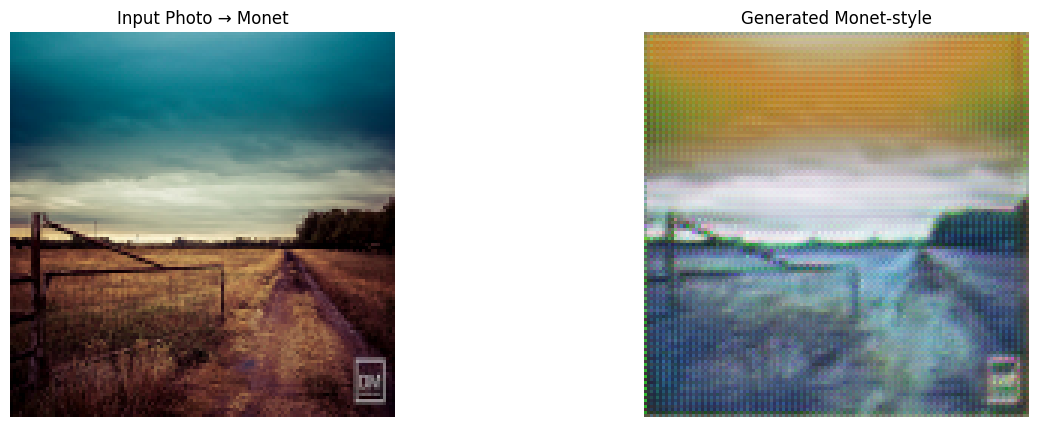

Step 991/1266 - M-disc: 0.2001, P-disc: 0.2902, M-gen: 0.3241, P-gen: 0.3394, Cycle: 0.5395, Identity: 0.5486

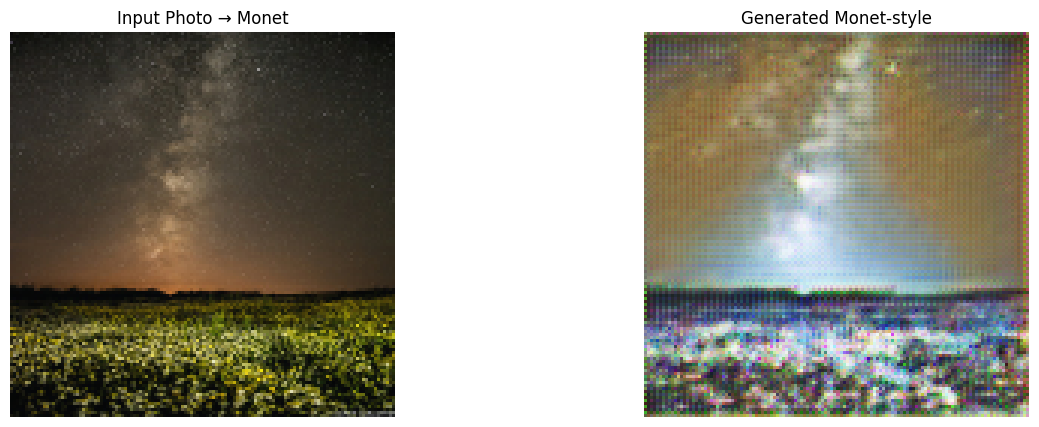

Step 1096/1266 - M-disc: 0.1605, P-disc: 0.2625, M-gen: 0.2974, P-gen: 0.3059, Cycle: 0.4625, Identity: 0.5380

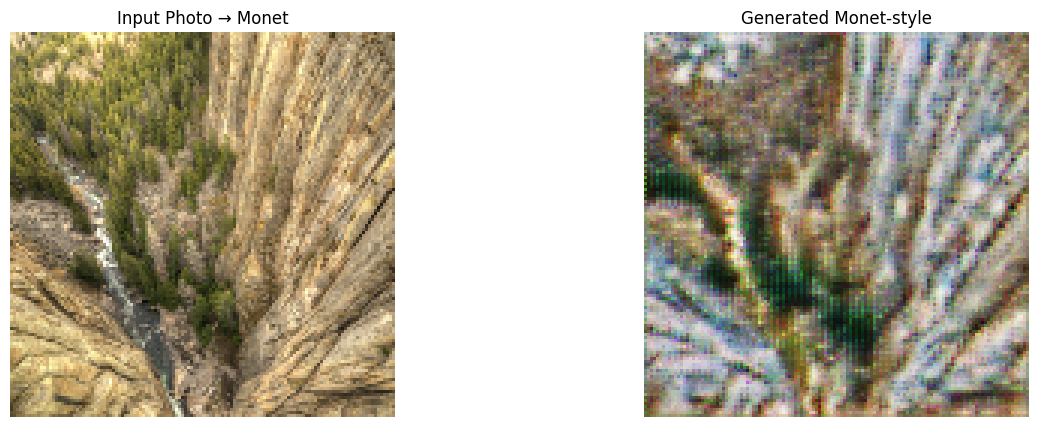

Step 1186/1266 - M-disc: 0.2577, P-disc: 0.1650, M-gen: 0.3632, P-gen: 0.2493, Cycle: 0.7050, Identity: 0.8086

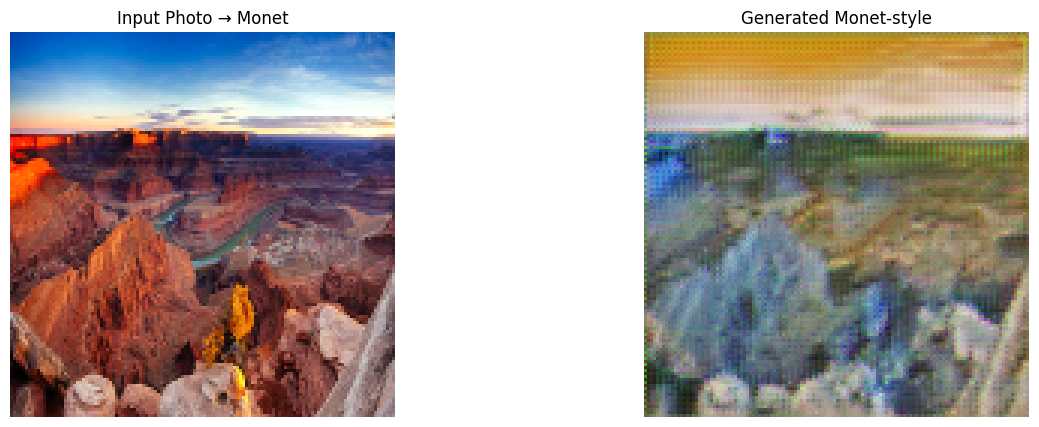

Step 1261/1266 - M-disc: 0.1394, P-disc: 0.1758, M-gen: 0.6214, P-gen: 0.2289, Cycle: 0.7152, Identity: 0.7540
Epoch 1 completed in 2296s - avg M-disc: 0.2192, avg P-disc: 0.2475, avg M-gen: 0.3644, avg P-gen: 0.3680, avg Cycle: 0.5521, avg Identity: 0.6293

Epoch 2/2


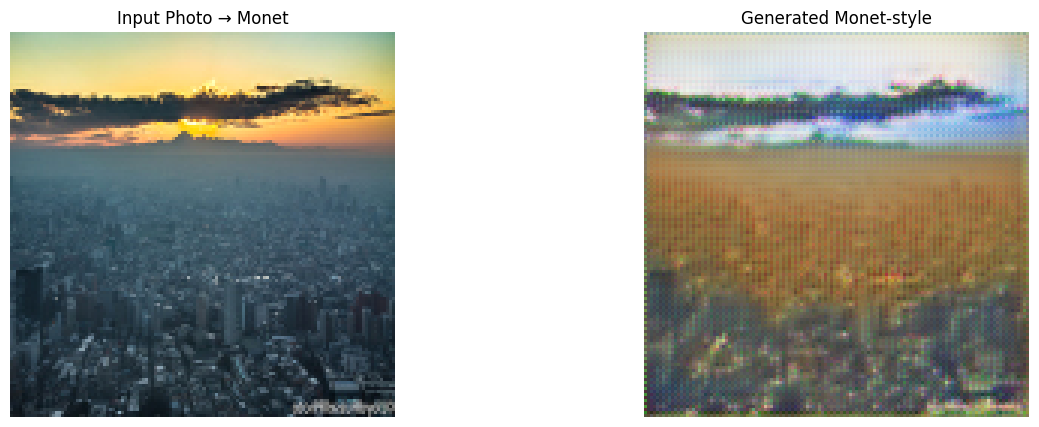

Step 91/1266 - M-disc: 0.2165, P-disc: 0.1908, M-gen: 0.3732, P-gen: 0.3394, Cycle: 0.4594, Identity: 0.6959

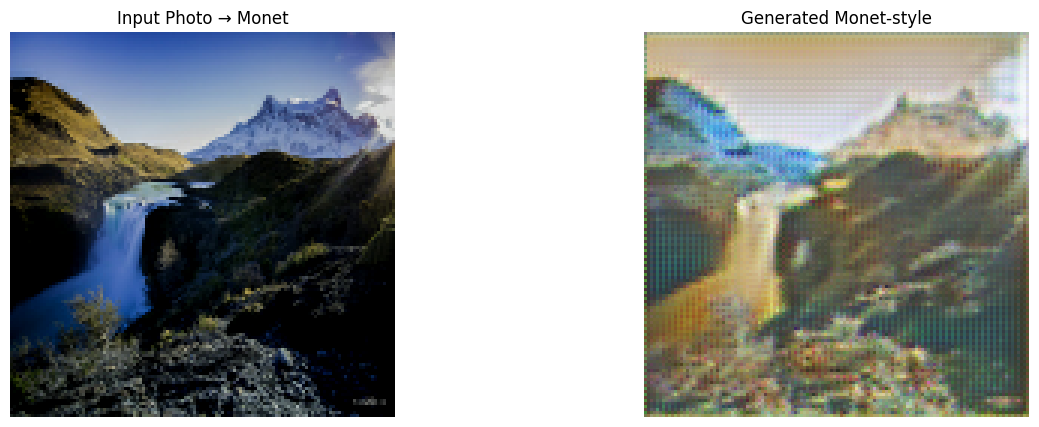

Step 196/1266 - M-disc: 0.1517, P-disc: 0.2127, M-gen: 0.3356, P-gen: 0.2041, Cycle: 0.6677, Identity: 0.6797

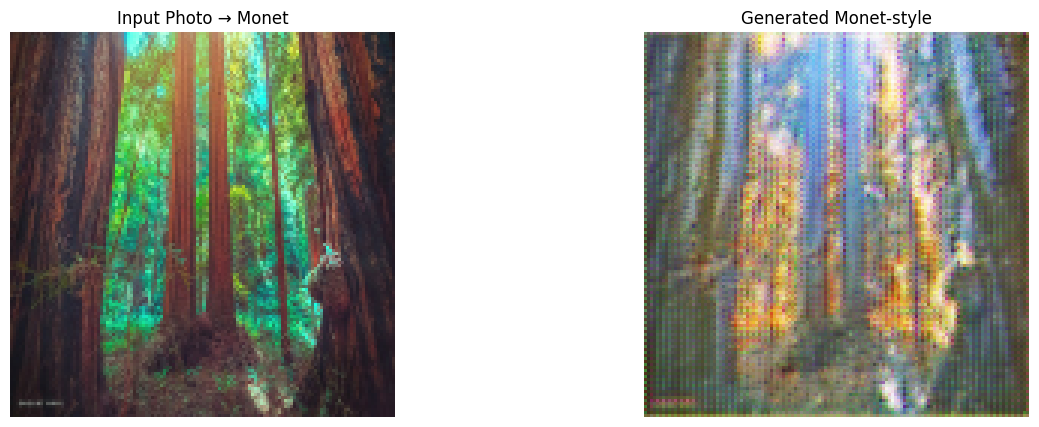

Step 286/1266 - M-disc: 0.1619, P-disc: 0.2702, M-gen: 0.3414, P-gen: 0.2467, Cycle: 0.2746, Identity: 0.4013

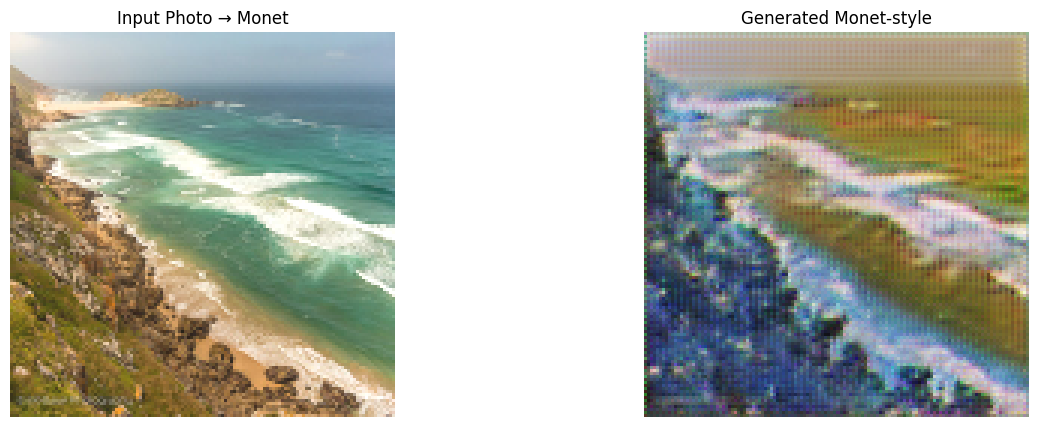

Step 391/1266 - M-disc: 0.3043, P-disc: 0.2151, M-gen: 0.2210, P-gen: 0.3749, Cycle: 0.4225, Identity: 0.5114

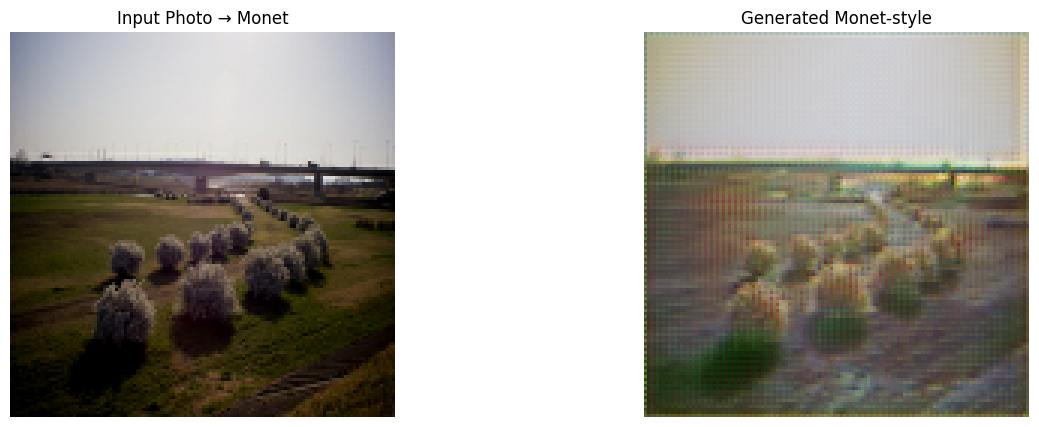

Step 496/1266 - M-disc: 0.2768, P-disc: 0.3069, M-gen: 0.1843, P-gen: 0.2737, Cycle: 0.3610, Identity: 0.4033

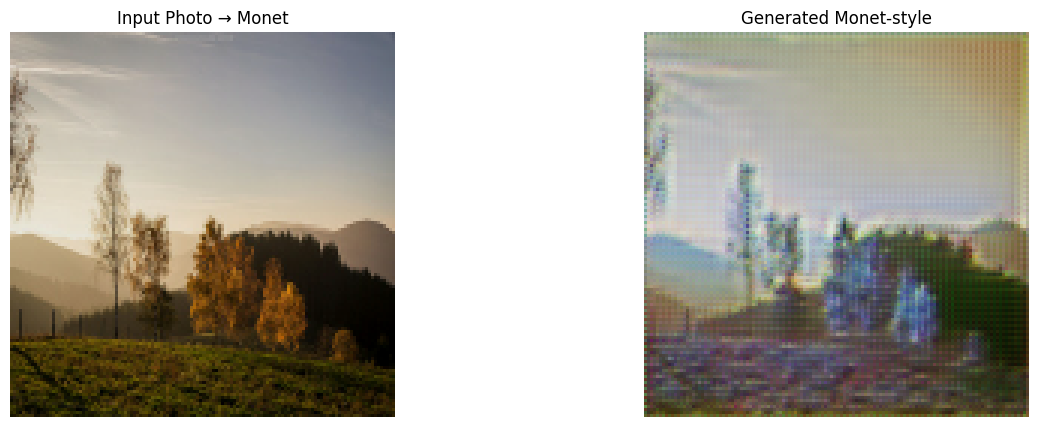

Step 586/1266 - M-disc: 0.2257, P-disc: 0.1530, M-gen: 0.2926, P-gen: 0.3221, Cycle: 0.6510, Identity: 0.7439

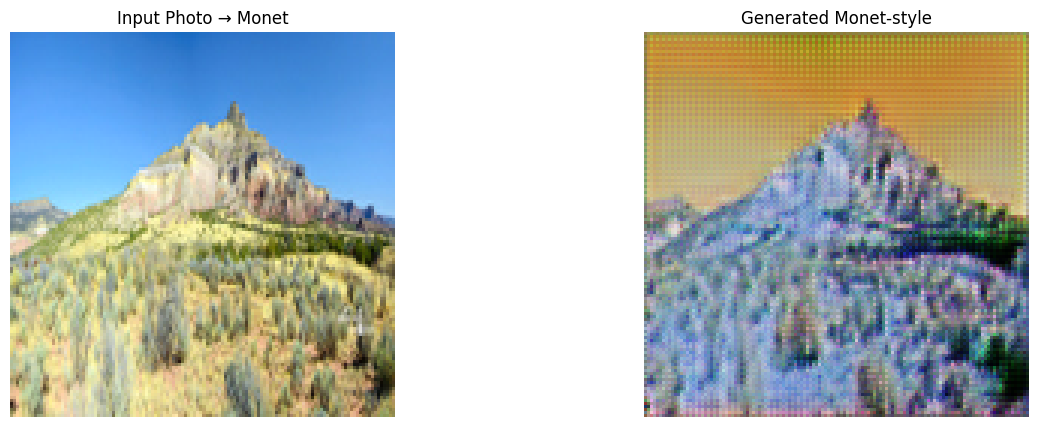

Step 691/1266 - M-disc: 0.1816, P-disc: 0.2564, M-gen: 0.3338, P-gen: 0.3204, Cycle: 0.3525, Identity: 0.4657

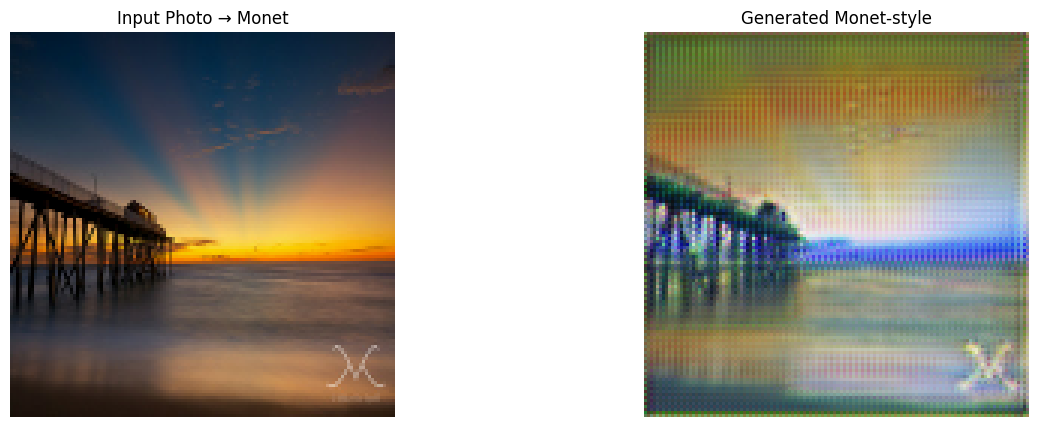

Step 796/1266 - M-disc: 0.2853, P-disc: 0.1925, M-gen: 0.4168, P-gen: 0.2547, Cycle: 0.4595, Identity: 0.6966

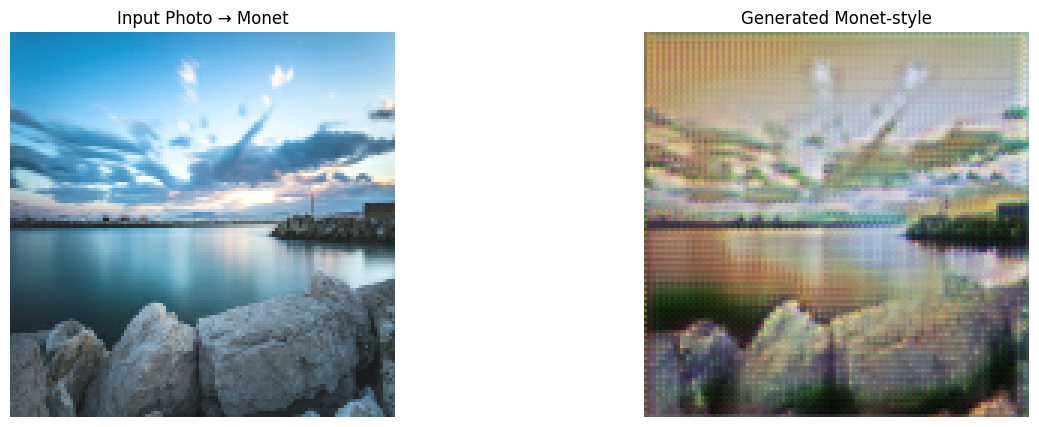

Step 886/1266 - M-disc: 0.2012, P-disc: 0.1532, M-gen: 0.3441, P-gen: 0.3918, Cycle: 0.3684, Identity: 0.4536

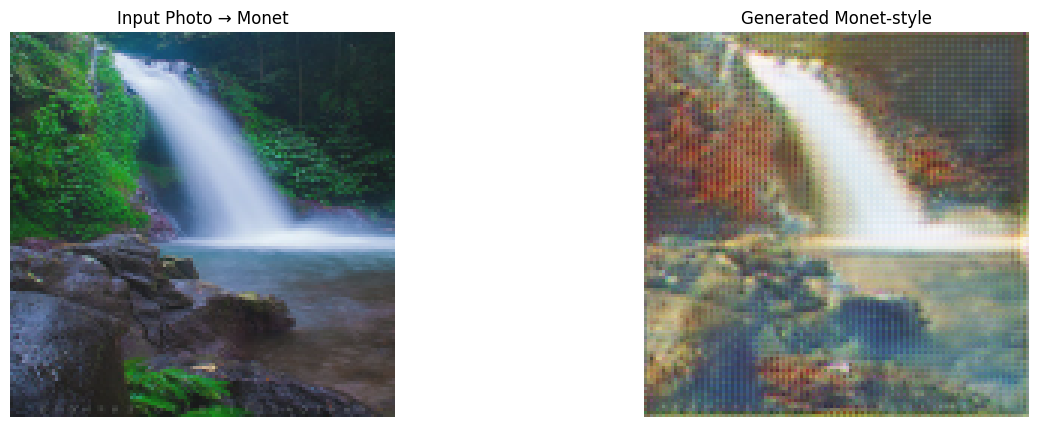

Step 991/1266 - M-disc: 0.1991, P-disc: 0.1799, M-gen: 0.3795, P-gen: 0.3414, Cycle: 0.3181, Identity: 0.6177

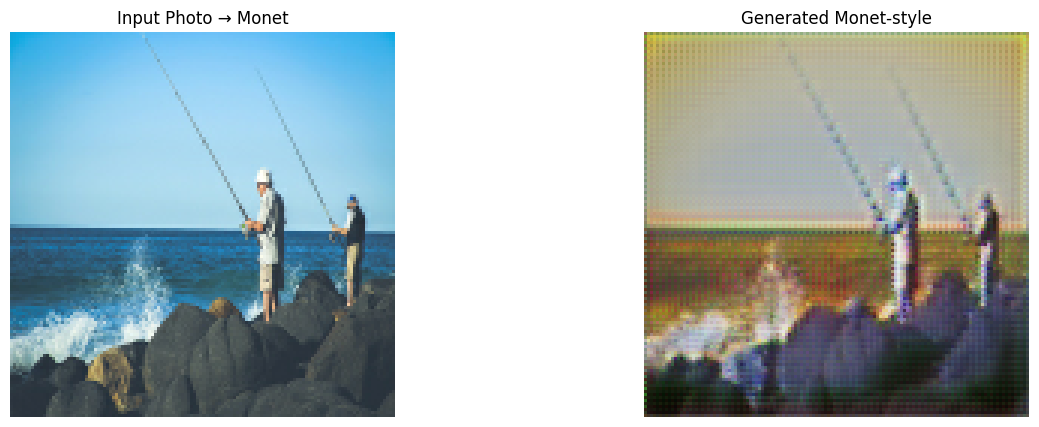

Step 1096/1266 - M-disc: 0.1652, P-disc: 0.2989, M-gen: 0.3102, P-gen: 0.2991, Cycle: 0.4150, Identity: 0.5898

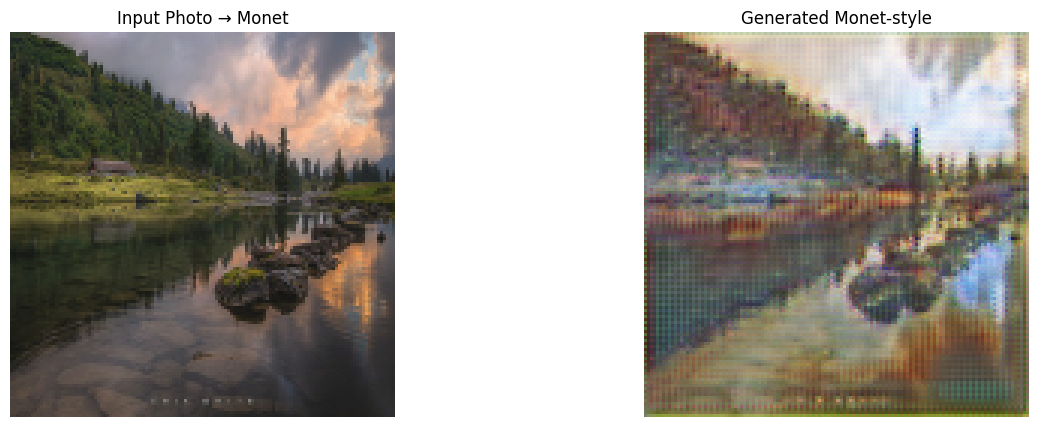

Step 1186/1266 - M-disc: 0.1624, P-disc: 0.1311, M-gen: 0.3664, P-gen: 0.3126, Cycle: 0.5034, Identity: 0.5852

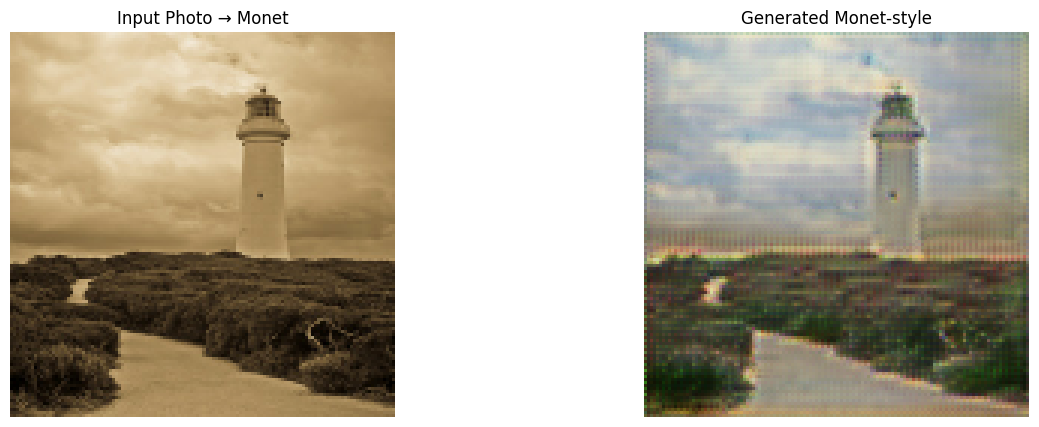

Step 1261/1266 - M-disc: 0.2374, P-disc: 0.1913, M-gen: 0.3696, P-gen: 0.3764, Cycle: 0.4910, Identity: 0.6217
Epoch 2 completed in 2368s - avg M-disc: 0.2184, avg P-disc: 0.2286, avg M-gen: 0.3421, avg P-gen: 0.3179, avg Cycle: 0.4974, avg Identity: 0.6239


In [17]:
from keras.optimizers import Adam
import numpy as np
import time

NUM_EPOCHS = 2
EPOCH_LENGTH = DATASET_HEIGHT // 5
DISPLAY_INTERVAL = 15  # record loss every 5 steps

# Optimizers for all models
monet_gen_opt = Adam(learning_rate=2e-4, beta_1=0.5)
photo_gen_opt = Adam(learning_rate=2e-4, beta_1=0.5)
monet_disc_opt = Adam(learning_rate=2e-4, beta_1=0.5)
photo_disc_opt = Adam(learning_rate=2e-4, beta_1=0.5)

# Initialize models
monet_generator = Generator((128, 128, 3), strides=2)
photo_generator = Generator((128, 128, 3), strides=2)
monet_discriminator = build_discriminator()
photo_discriminator = build_discriminator()

eg_image = augment_and_normalize(next(my_image_ds_train))
eg_output = monet_generator(eg_image)

all_losses = []

for i in range(NUM_EPOCHS):
    print(f"\nEpoch {i + 1}/{NUM_EPOCHS}")
    epoch_losses = []
    start_time = time.time()

    for j in range(EPOCH_LENGTH):
        monet_image = next(my_monet_ds_train)
        photo_image = next(my_image_ds_train)
        
        # Apply random augmentation
        monet_image = augment_and_normalize(monet_image)
        photo_image = augment_and_normalize(photo_image)

        # Display progress images every 1000 steps
        if j % 100 == 0:
            test_photo_to_monet = monet_generator(photo_image)
            test_monet_to_photo = photo_generator(monet_image)
            
            plt.figure(figsize=(15, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(to_display(photo_image[0]))
            plt.title('Input Photo → Monet')
            plt.axis('off')
            
            plt.subplot(1, 2, 2)
            plt.imshow(to_display(test_photo_to_monet[0]))
            plt.title('Generated Monet-style')
            plt.axis('off')
            plt.show()
            plt.close()

        with tf.GradientTape(persistent=True) as tape:
            # Generate fake images
            fake_monet = monet_generator(photo_image)
            fake_photo = photo_generator(monet_image)
            
            # Cycle consistency
            cycled_photo = photo_generator(fake_monet)
            cycled_monet = monet_generator(fake_photo)
            
            # Identity mapping
            same_monet = monet_generator(monet_image)
            same_photo = photo_generator(photo_image)

            # Discriminator outputs
            disc_real_monet = monet_discriminator(monet_image)
            disc_fake_monet = monet_discriminator(fake_monet)
            disc_real_photo = photo_discriminator(photo_image)
            disc_fake_photo = photo_discriminator(fake_photo)

            # Calculate losses
            monet_disc_loss = 0.5 * (
                my_square_loss(tf.constant(1.0), disc_real_monet) +
                my_square_loss(tf.constant(0.0), disc_fake_monet)
            )
            photo_disc_loss = 0.5 * (
                my_square_loss(tf.constant(1.0), disc_real_photo) +
                my_square_loss(tf.constant(0.0), disc_fake_photo)
            )

            # Generator adversarial losses
            monet_gen_loss = generator_loss(disc_fake_monet)
            photo_gen_loss = generator_loss(disc_fake_photo)

            # Cycle consistency losses
            cycle_loss = tf.reduce_mean(tf.abs(photo_image - cycled_photo)) + \
                        tf.reduce_mean(tf.abs(monet_image - cycled_monet))
            
            # Identity losses
            identity_loss = tf.reduce_mean(tf.abs(monet_image - same_monet)) + \
                          tf.reduce_mean(tf.abs(photo_image - same_photo))

            # Total generator losses
            total_monet_gen_loss = monet_gen_loss + 10 * cycle_loss + 0.5 * identity_loss
            total_photo_gen_loss = photo_gen_loss + 10 * cycle_loss + 0.5 * identity_loss

        if j % 3 == 0:
            # Train discriminators
            monet_disc_grads = tape.gradient(monet_disc_loss, monet_discriminator.trainable_variables)
            photo_disc_grads = tape.gradient(photo_disc_loss, photo_discriminator.trainable_variables)
            
            monet_disc_opt.apply_gradients(zip(monet_disc_grads, monet_discriminator.trainable_variables))
            photo_disc_opt.apply_gradients(zip(photo_disc_grads, photo_discriminator.trainable_variables))
        else:
            # Train generators
            monet_gen_grads = tape.gradient(total_monet_gen_loss, monet_generator.trainable_variables)
            photo_gen_grads = tape.gradient(total_photo_gen_loss, photo_generator.trainable_variables)
            
            monet_gen_opt.apply_gradients(zip(monet_gen_grads, monet_generator.trainable_variables))
            photo_gen_opt.apply_gradients(zip(photo_gen_grads, photo_generator.trainable_variables))

        if j % DISPLAY_INTERVAL == 0:
            losses = (
                tf.squeeze(monet_disc_loss).numpy(),
                tf.squeeze(photo_disc_loss).numpy(),
                tf.squeeze(monet_gen_loss).numpy(),
                tf.squeeze(photo_gen_loss).numpy(),
                tf.squeeze(cycle_loss).numpy(),
                tf.squeeze(identity_loss).numpy()
            )
            epoch_losses.append(losses)
            print(f"\rStep {j + 1}/{EPOCH_LENGTH} - "
                  f"M-disc: {losses[0]:.4f}, P-disc: {losses[1]:.4f}, "
                  f"M-gen: {losses[2]:.4f}, P-gen: {losses[3]:.4f}, "
                  f"Cycle: {losses[4]:.4f}, Identity: {losses[5]:.4f}", end='')

    # Calculate epoch averages
    epoch_avgs = np.mean(epoch_losses, axis=0)
    print(f"\nEpoch {i + 1} completed in {int(time.time() - start_time)}s - "
          f"avg M-disc: {epoch_avgs[0]:.4f}, avg P-disc: {epoch_avgs[1]:.4f}, "
          f"avg M-gen: {epoch_avgs[2]:.4f}, avg P-gen: {epoch_avgs[3]:.4f}, "
          f"avg Cycle: {epoch_avgs[4]:.4f}, avg Identity: {epoch_avgs[5]:.4f}")
    all_losses.extend(epoch_losses)



Epoch 1/2


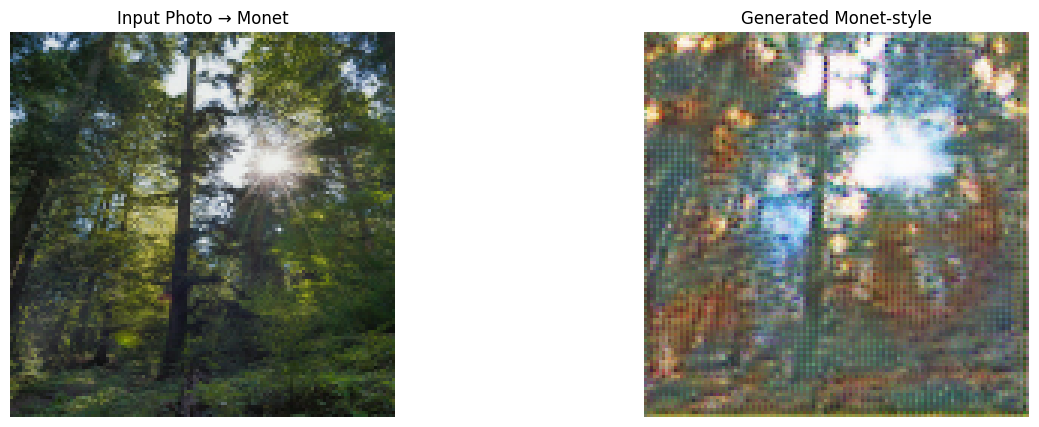

Step 91/1266 - M-disc: 0.1876, P-disc: 0.2746, M-gen: 0.1987, P-gen: 0.3220, Cycle: 0.6611, Identity: 0.6935

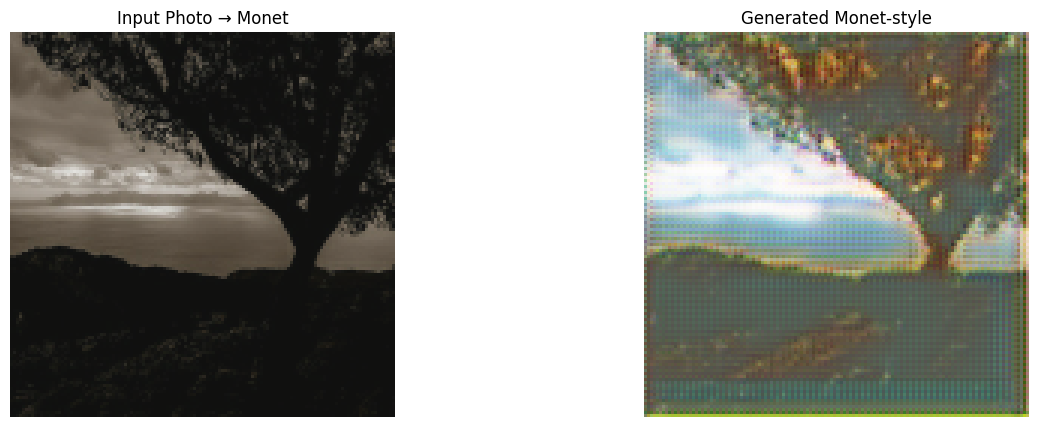

Step 196/1266 - M-disc: 0.2632, P-disc: 0.2117, M-gen: 0.4135, P-gen: 0.2221, Cycle: 0.4745, Identity: 0.6760

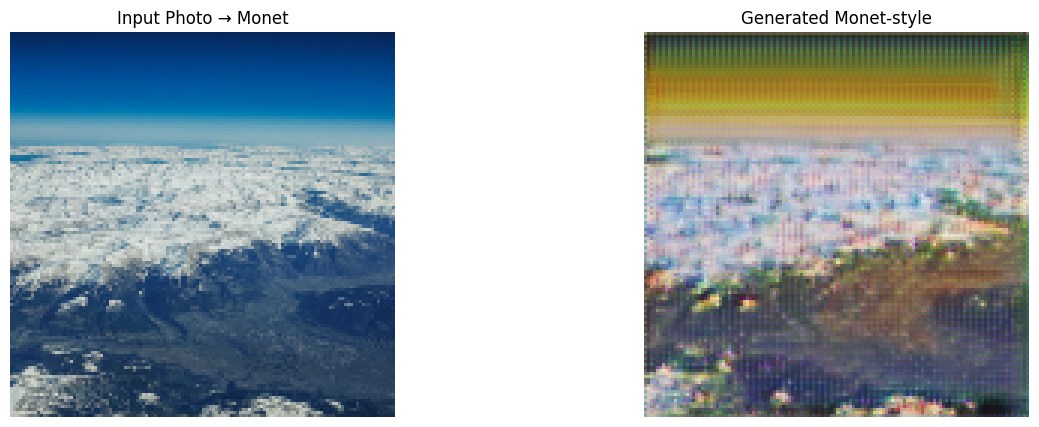

Step 286/1266 - M-disc: 0.2203, P-disc: 0.2280, M-gen: 0.2357, P-gen: 0.3197, Cycle: 0.5180, Identity: 0.6168

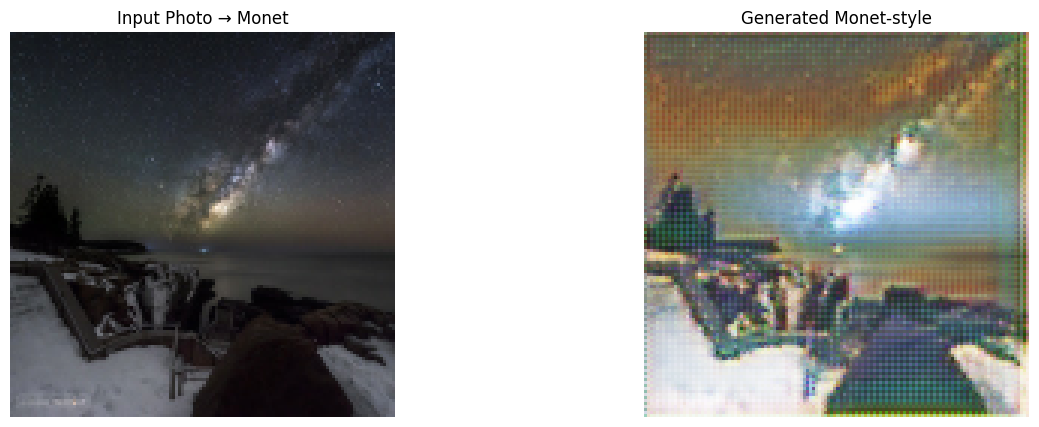

Step 391/1266 - M-disc: 0.2523, P-disc: 0.3299, M-gen: 0.2815, P-gen: 0.3962, Cycle: 0.3361, Identity: 0.4641

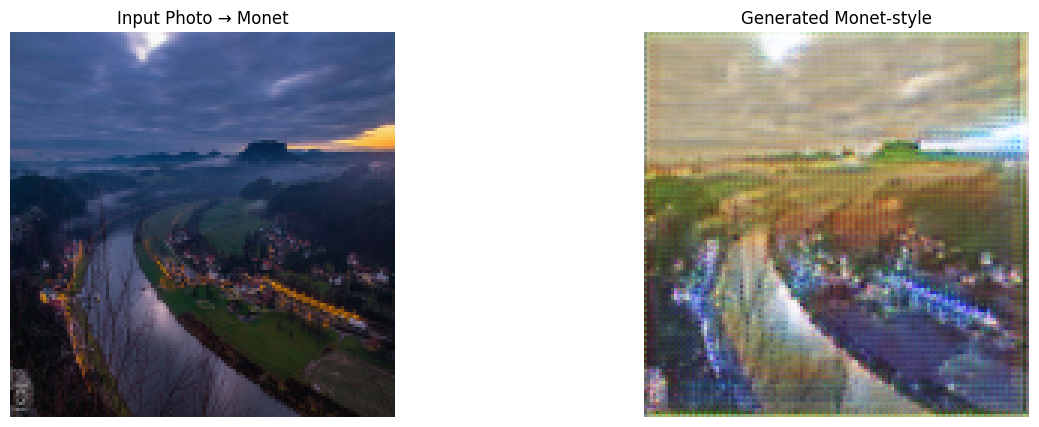

Step 496/1266 - M-disc: 0.1490, P-disc: 0.1329, M-gen: 0.4477, P-gen: 0.4419, Cycle: 0.3889, Identity: 0.5962

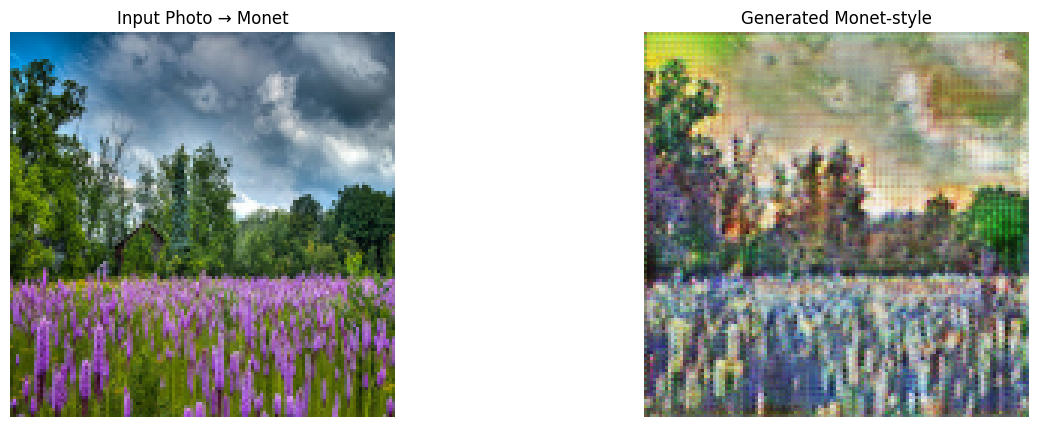

Step 586/1266 - M-disc: 0.3101, P-disc: 0.3016, M-gen: 0.3957, P-gen: 0.4010, Cycle: 0.3783, Identity: 0.4528

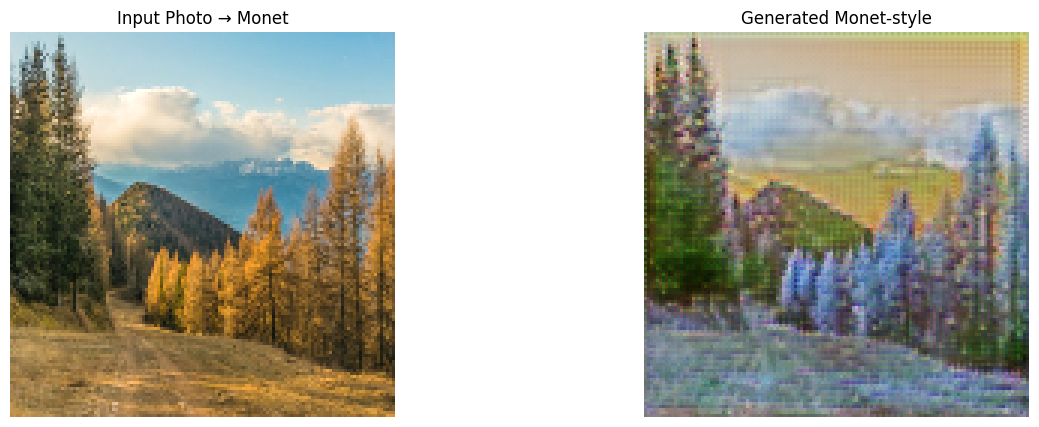

Step 691/1266 - M-disc: 0.1792, P-disc: 0.1764, M-gen: 0.5127, P-gen: 0.3155, Cycle: 0.4000, Identity: 0.5930

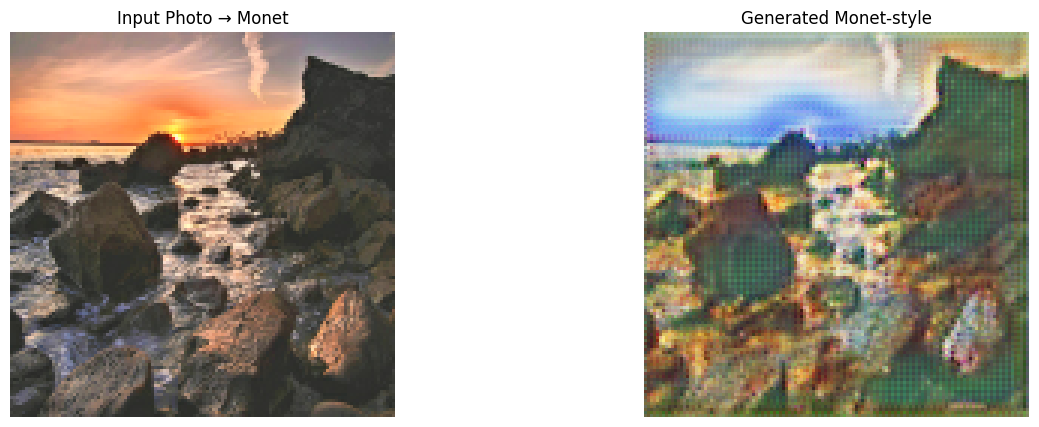

Step 796/1266 - M-disc: 0.2563, P-disc: 0.2304, M-gen: 0.3794, P-gen: 0.3353, Cycle: 0.3090, Identity: 0.6431

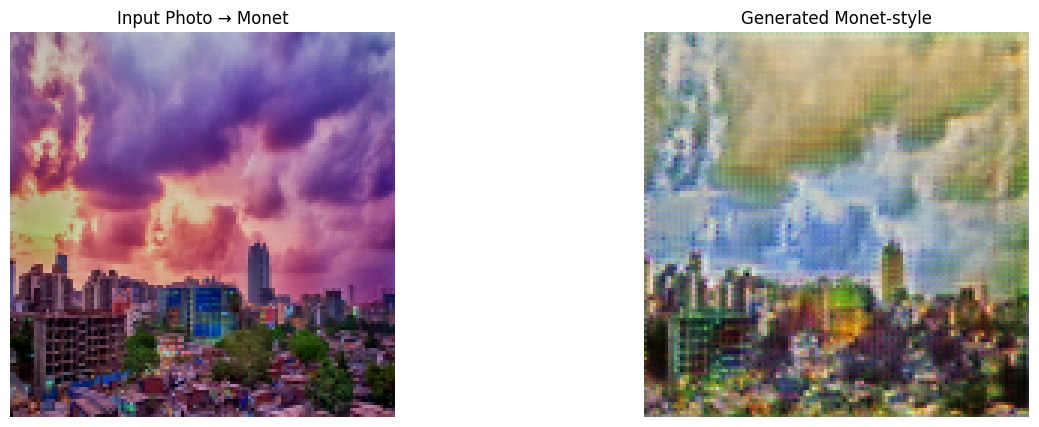

Step 886/1266 - M-disc: 0.1703, P-disc: 0.1728, M-gen: 0.3693, P-gen: 0.4283, Cycle: 0.4924, Identity: 0.6415

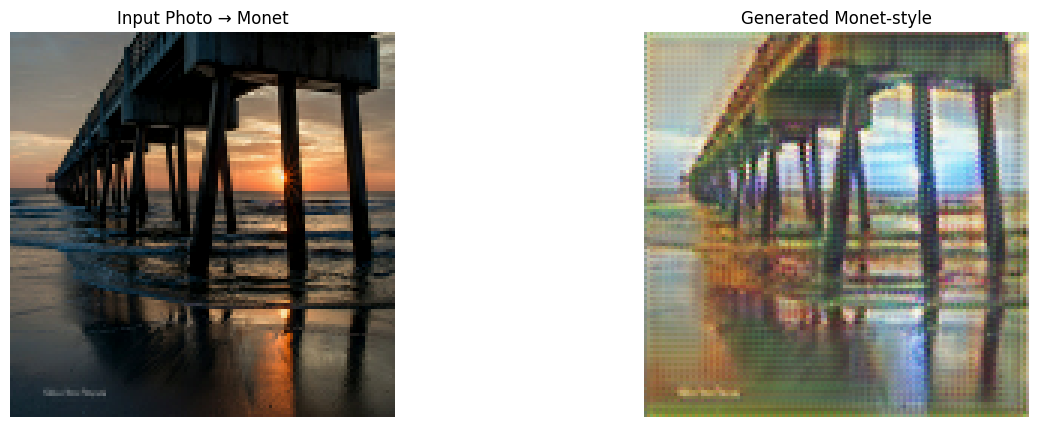

Step 991/1266 - M-disc: 0.2082, P-disc: 0.1975, M-gen: 0.1666, P-gen: 0.3133, Cycle: 0.6018, Identity: 0.7388

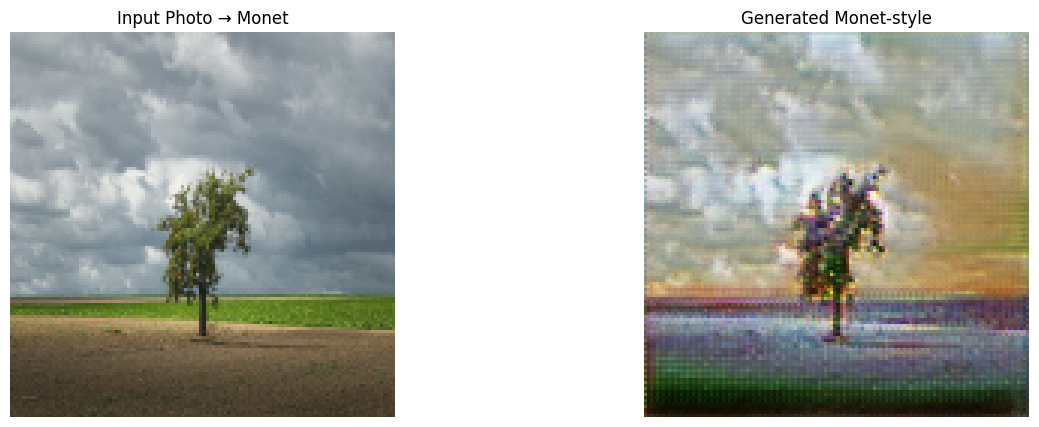

Step 1096/1266 - M-disc: 0.2576, P-disc: 0.1701, M-gen: 0.4723, P-gen: 0.3520, Cycle: 0.2952, Identity: 0.4114

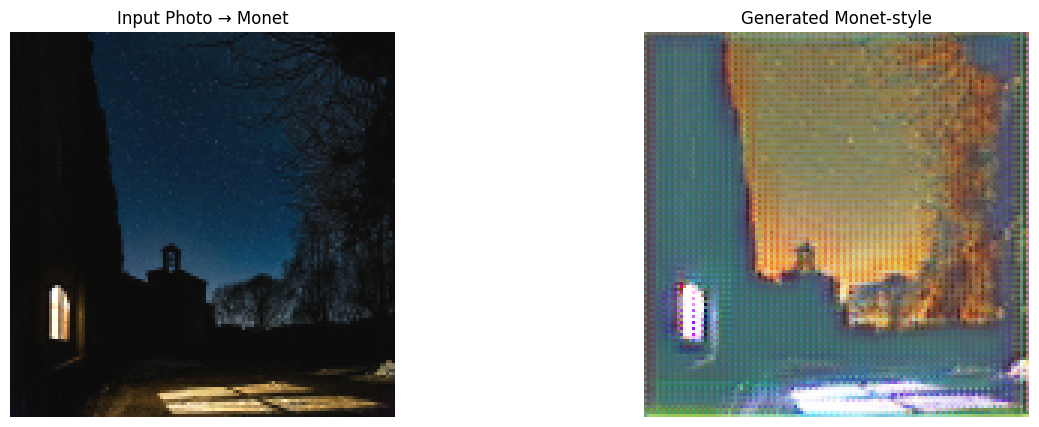

Step 1186/1266 - M-disc: 0.3031, P-disc: 0.3066, M-gen: 0.2332, P-gen: 0.3130, Cycle: 0.2779, Identity: 0.4576

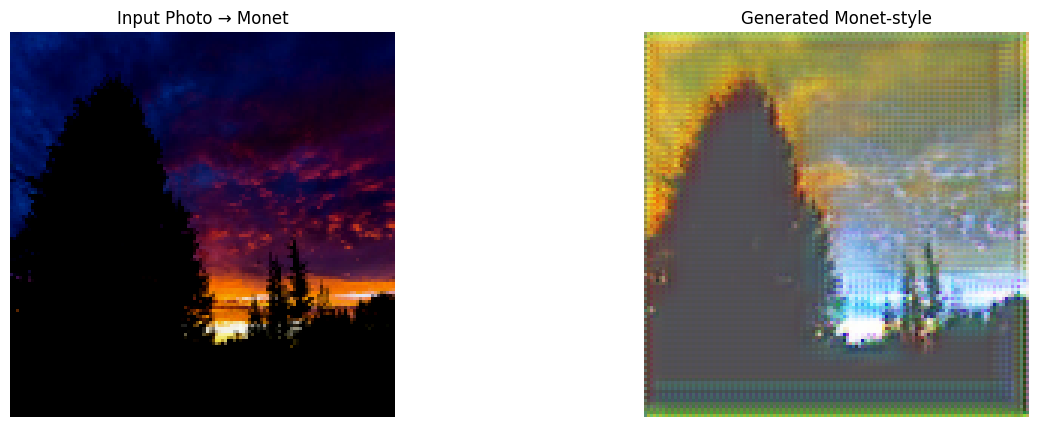

Step 1261/1266 - M-disc: 0.1820, P-disc: 0.1991, M-gen: 0.3348, P-gen: 0.2854, Cycle: 0.2918, Identity: 0.4957
Epoch 1 completed in 2487s - avg M-disc: 0.2254, avg P-disc: 0.2170, avg M-gen: 0.3382, avg P-gen: 0.3313, avg Cycle: 0.4370, avg Identity: 0.5992

Epoch 2/2


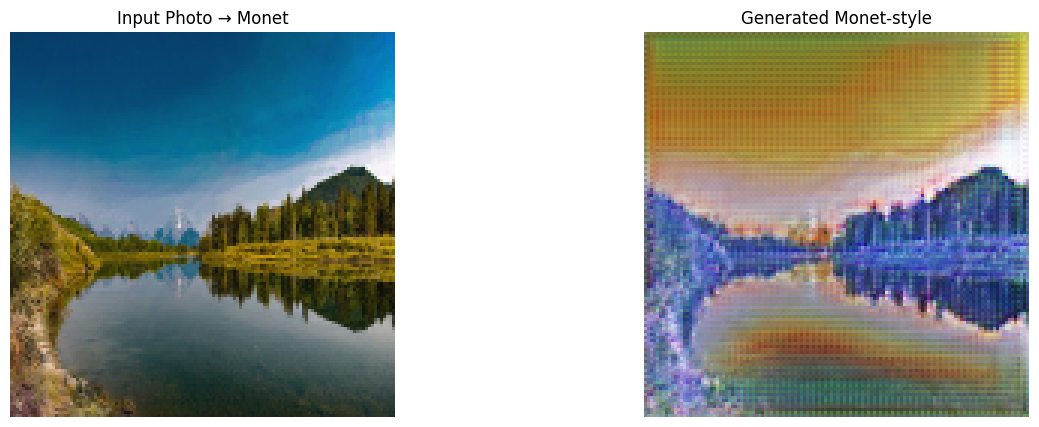

Step 91/1266 - M-disc: 0.2401, P-disc: 0.1772, M-gen: 0.3918, P-gen: 0.3502, Cycle: 0.4609, Identity: 0.6428

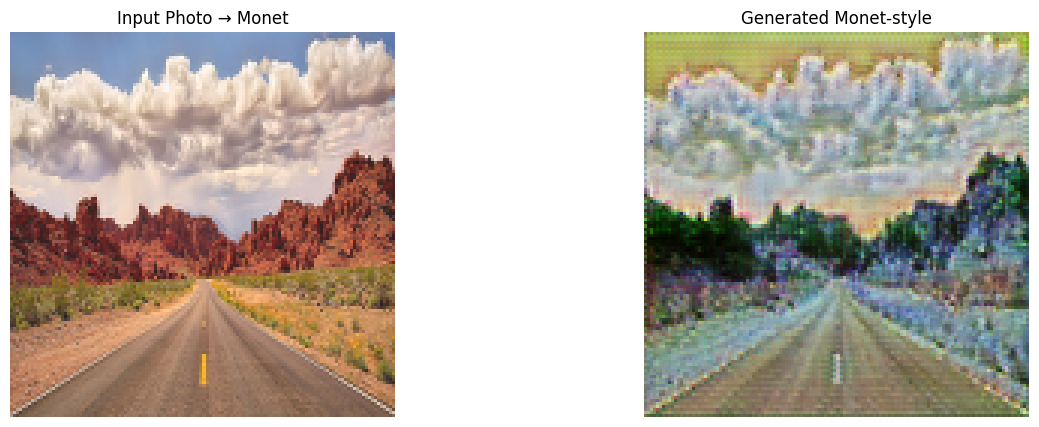

Step 196/1266 - M-disc: 0.1759, P-disc: 0.1971, M-gen: 0.2588, P-gen: 0.4422, Cycle: 0.6634, Identity: 0.7966

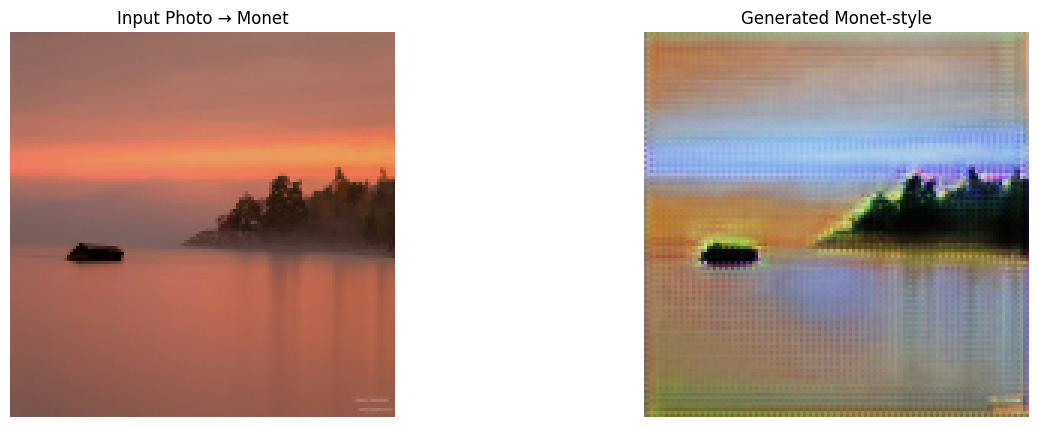

Step 286/1266 - M-disc: 0.2127, P-disc: 0.1602, M-gen: 0.4125, P-gen: 0.3334, Cycle: 0.6914, Identity: 0.8485

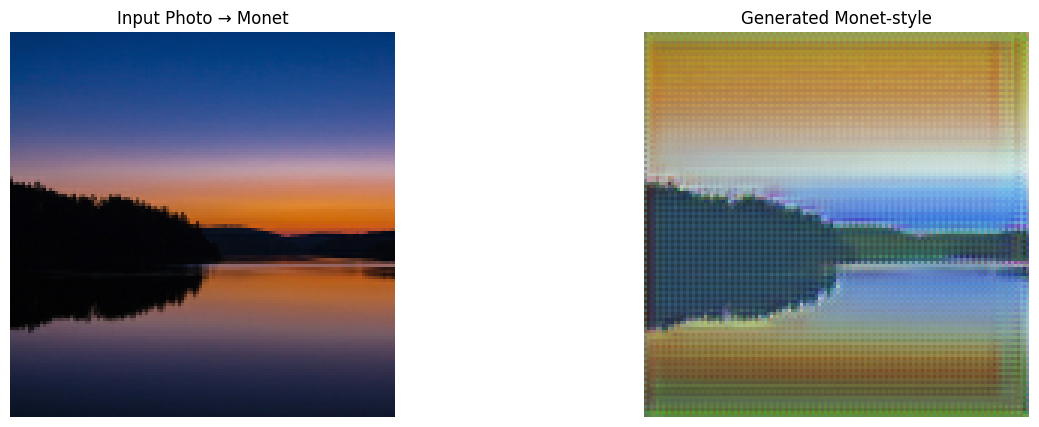

Step 391/1266 - M-disc: 0.1700, P-disc: 0.1879, M-gen: 0.3585, P-gen: 0.3338, Cycle: 0.5705, Identity: 0.6349

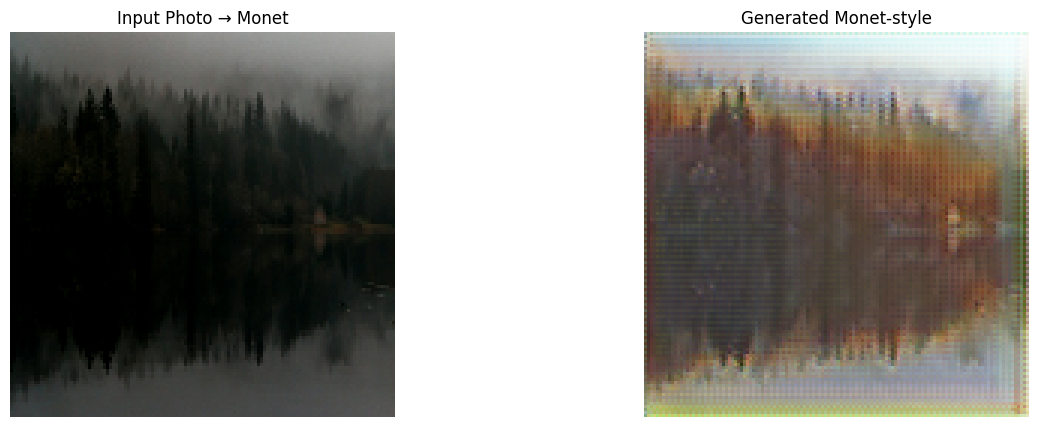

Step 496/1266 - M-disc: 0.2475, P-disc: 0.1843, M-gen: 0.2246, P-gen: 0.3702, Cycle: 0.6364, Identity: 0.7874

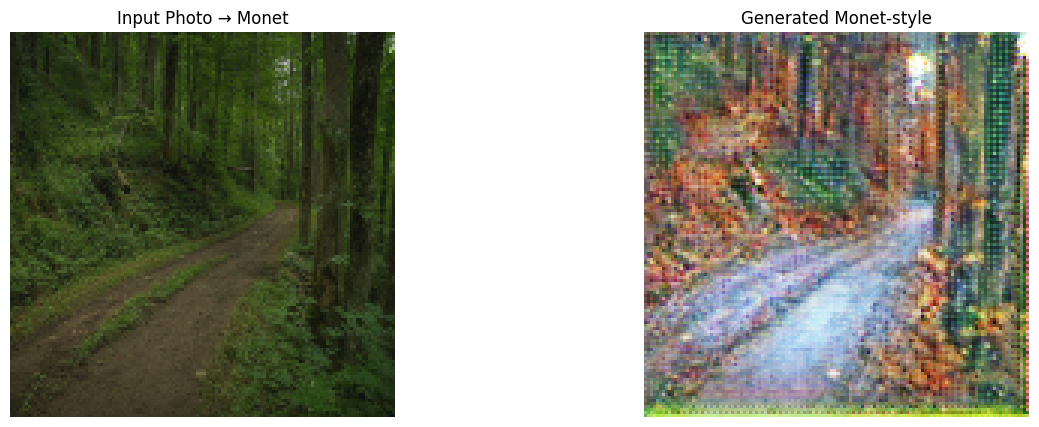

Step 586/1266 - M-disc: 0.1804, P-disc: 0.1461, M-gen: 0.2859, P-gen: 0.4747, Cycle: 0.4054, Identity: 0.7222

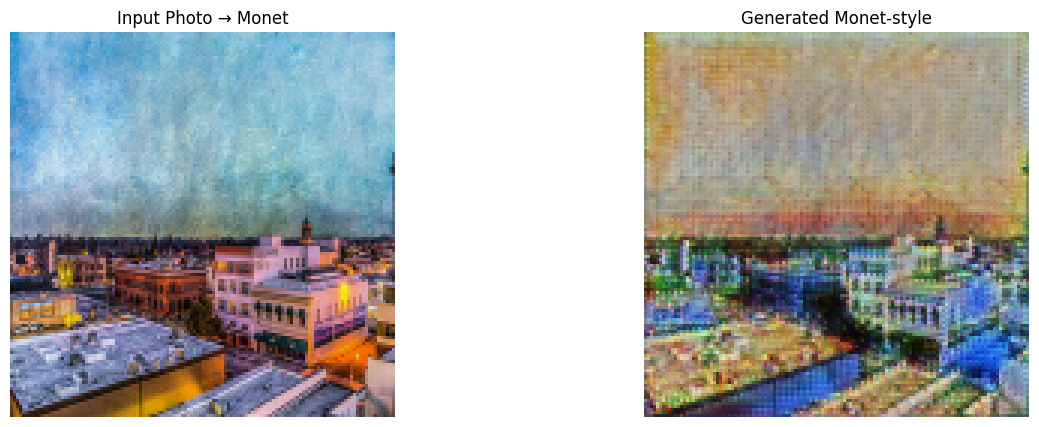

Step 691/1266 - M-disc: 0.2880, P-disc: 0.1568, M-gen: 0.2754, P-gen: 0.4653, Cycle: 0.5083, Identity: 0.7780

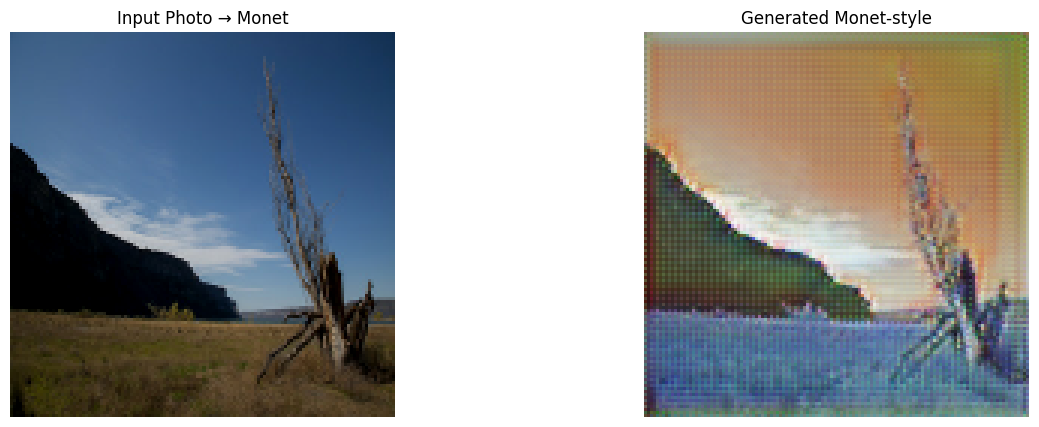

Step 766/1266 - M-disc: 0.2331, P-disc: 0.1791, M-gen: 0.3021, P-gen: 0.4672, Cycle: 0.3387, Identity: 0.4758

KeyboardInterrupt: 

In [18]:

for i in range(NUM_EPOCHS):
    print(f"\nEpoch {i + 1}/{NUM_EPOCHS}")
    epoch_losses = []
    start_time = time.time()

    for j in range(EPOCH_LENGTH):
        monet_image = next(my_monet_ds_train)
        photo_image = next(my_image_ds_train)
        
        # Apply random augmentation
        monet_image = augment_and_normalize(monet_image)
        photo_image = augment_and_normalize(photo_image)

        # Display progress images every 1000 steps
        if j % 100 == 0:
            test_photo_to_monet = monet_generator(photo_image)
            test_monet_to_photo = photo_generator(monet_image)
            
            plt.figure(figsize=(15, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(to_display(photo_image[0]))
            plt.title('Input Photo → Monet')
            plt.axis('off')
            
            plt.subplot(1, 2, 2)
            plt.imshow(to_display(test_photo_to_monet[0]))
            plt.title('Generated Monet-style')
            plt.axis('off')
            plt.show()
            plt.close()

        with tf.GradientTape(persistent=True) as tape:
            # Generate fake images
            fake_monet = monet_generator(photo_image)
            fake_photo = photo_generator(monet_image)
            
            # Cycle consistency
            cycled_photo = photo_generator(fake_monet)
            cycled_monet = monet_generator(fake_photo)
            
            # Identity mapping
            same_monet = monet_generator(monet_image)
            same_photo = photo_generator(photo_image)

            # Discriminator outputs
            disc_real_monet = monet_discriminator(monet_image)
            disc_fake_monet = monet_discriminator(fake_monet)
            disc_real_photo = photo_discriminator(photo_image)
            disc_fake_photo = photo_discriminator(fake_photo)

            # Calculate losses
            monet_disc_loss = 0.5 * (
                my_square_loss(tf.constant(1.0), disc_real_monet) +
                my_square_loss(tf.constant(0.0), disc_fake_monet)
            )
            photo_disc_loss = 0.5 * (
                my_square_loss(tf.constant(1.0), disc_real_photo) +
                my_square_loss(tf.constant(0.0), disc_fake_photo)
            )

            # Generator adversarial losses
            monet_gen_loss = generator_loss(disc_fake_monet)
            photo_gen_loss = generator_loss(disc_fake_photo)

            # Cycle consistency losses
            cycle_loss = tf.reduce_mean(tf.abs(photo_image - cycled_photo)) + \
                        tf.reduce_mean(tf.abs(monet_image - cycled_monet))
            
            # Identity losses
            identity_loss = tf.reduce_mean(tf.abs(monet_image - same_monet)) + \
                          tf.reduce_mean(tf.abs(photo_image - same_photo))

            # Total generator losses
            total_monet_gen_loss = monet_gen_loss + 10 * cycle_loss + 0.5 * identity_loss
            total_photo_gen_loss = photo_gen_loss + 10 * cycle_loss + 0.5 * identity_loss

        if j % 3 == 0:
            # Train discriminators
            monet_disc_grads = tape.gradient(monet_disc_loss, monet_discriminator.trainable_variables)
            photo_disc_grads = tape.gradient(photo_disc_loss, photo_discriminator.trainable_variables)
            
            monet_disc_opt.apply_gradients(zip(monet_disc_grads, monet_discriminator.trainable_variables))
            photo_disc_opt.apply_gradients(zip(photo_disc_grads, photo_discriminator.trainable_variables))
        else:
            # Train generators
            monet_gen_grads = tape.gradient(total_monet_gen_loss, monet_generator.trainable_variables)
            photo_gen_grads = tape.gradient(total_photo_gen_loss, photo_generator.trainable_variables)
            
            monet_gen_opt.apply_gradients(zip(monet_gen_grads, monet_generator.trainable_variables))
            photo_gen_opt.apply_gradients(zip(photo_gen_grads, photo_generator.trainable_variables))

        if j % DISPLAY_INTERVAL == 0:
            losses = (
                tf.squeeze(monet_disc_loss).numpy(),
                tf.squeeze(photo_disc_loss).numpy(),
                tf.squeeze(monet_gen_loss).numpy(),
                tf.squeeze(photo_gen_loss).numpy(),
                tf.squeeze(cycle_loss).numpy(),
                tf.squeeze(identity_loss).numpy()
            )
            epoch_losses.append(losses)
            print(f"\rStep {j + 1}/{EPOCH_LENGTH} - "
                  f"M-disc: {losses[0]:.4f}, P-disc: {losses[1]:.4f}, "
                  f"M-gen: {losses[2]:.4f}, P-gen: {losses[3]:.4f}, "
                  f"Cycle: {losses[4]:.4f}, Identity: {losses[5]:.4f}", end='')

    # Calculate epoch averages
    epoch_avgs = np.mean(epoch_losses, axis=0)
    print(f"\nEpoch {i + 1} completed in {int(time.time() - start_time)}s - "
          f"avg M-disc: {epoch_avgs[0]:.4f}, avg P-disc: {epoch_avgs[1]:.4f}, "
          f"avg M-gen: {epoch_avgs[2]:.4f}, avg P-gen: {epoch_avgs[3]:.4f}, "
          f"avg Cycle: {epoch_avgs[4]:.4f}, avg Identity: {epoch_avgs[5]:.4f}")
    all_losses.extend(epoch_losses)

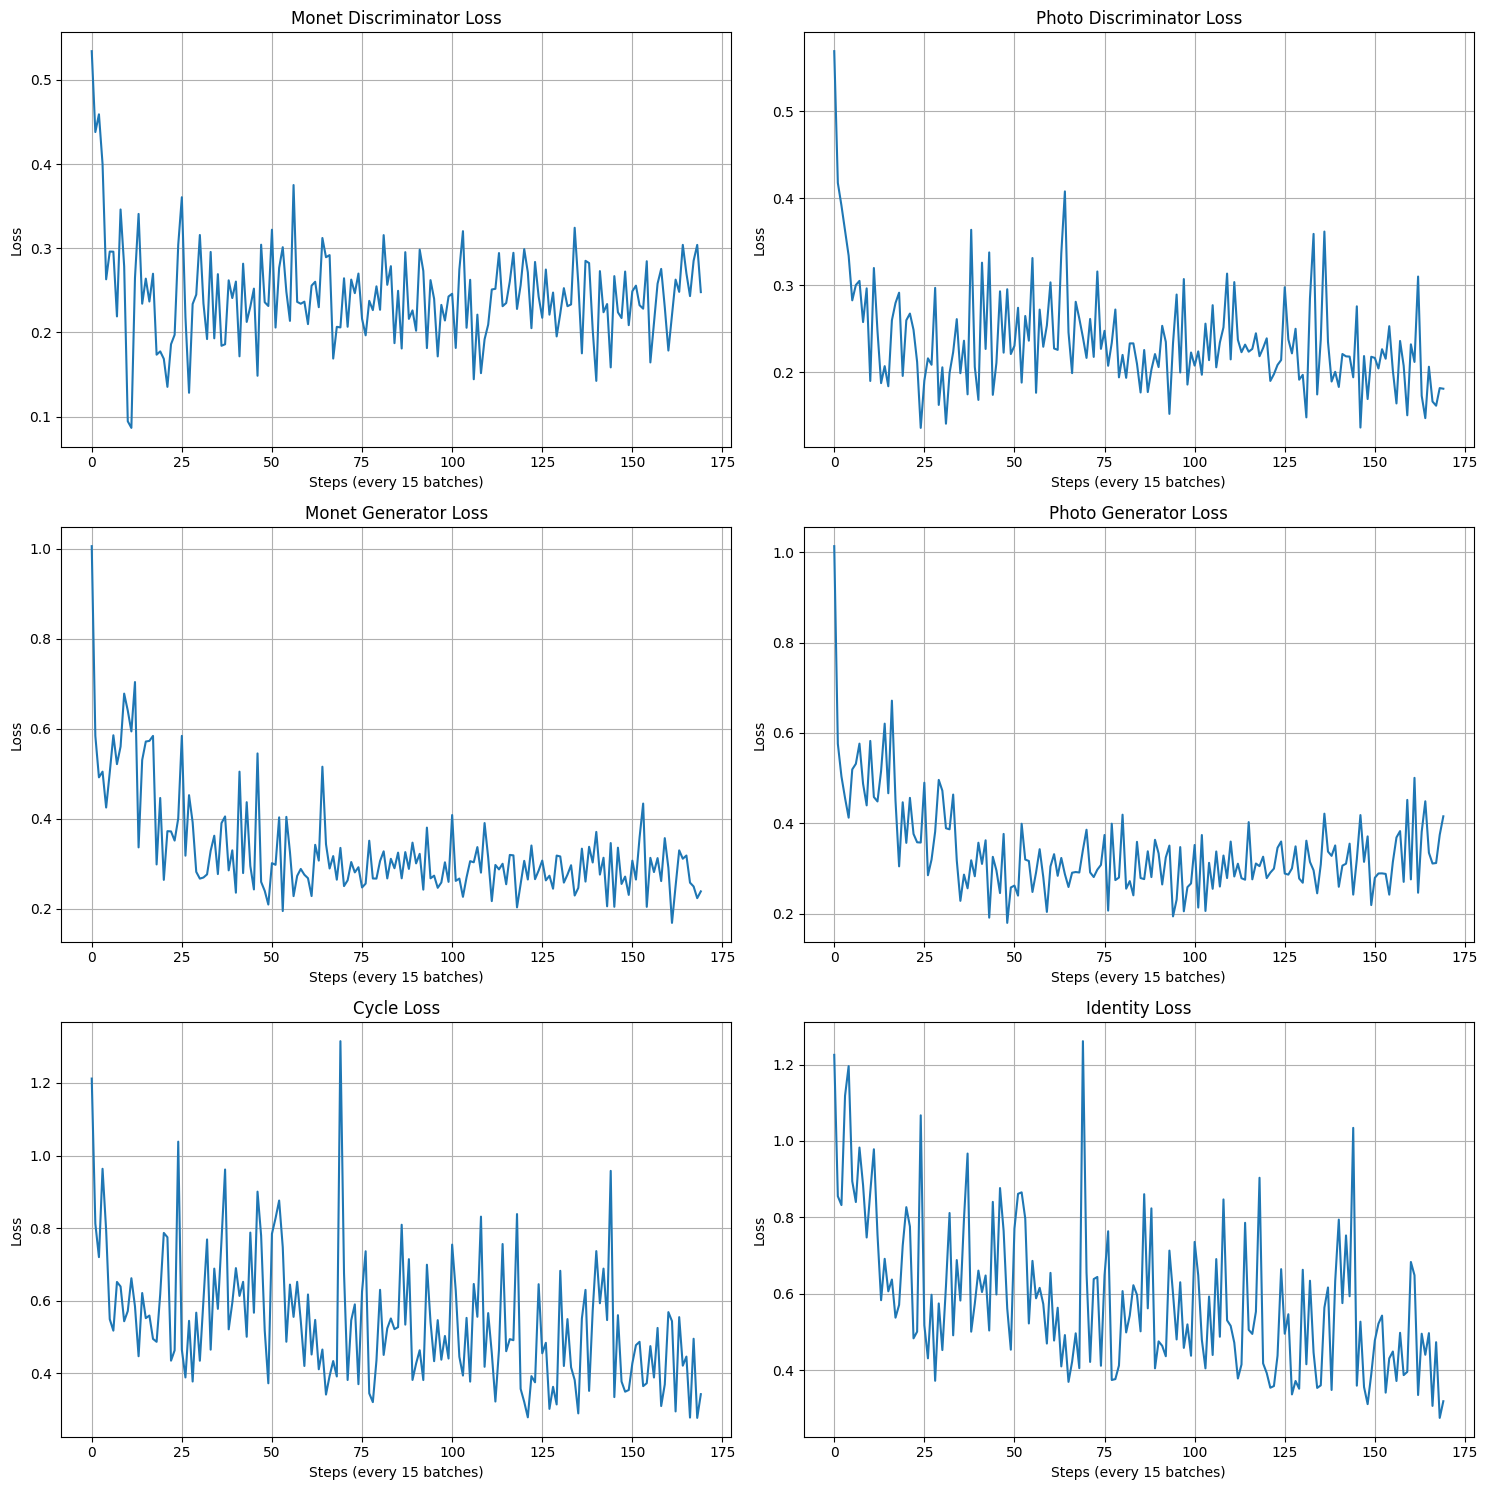

In [32]:
# Plot the losses over time
plt.figure(figsize=(15, 15))

plt.subplot(3, 2, 1)
plt.plot([l[0] for l in all_losses], label='Monet Discriminator')
plt.title('Monet Discriminator Loss')
plt.xlabel(f'Steps (every {DISPLAY_INTERVAL} batches)')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(3, 2, 2)
plt.plot([l[1] for l in all_losses], label='Photo Discriminator')
plt.title('Photo Discriminator Loss') 
plt.xlabel(f'Steps (every {DISPLAY_INTERVAL} batches)')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(3, 2, 3)
plt.plot([l[2] for l in all_losses], label='Monet Generator')
plt.title('Monet Generator Loss')
plt.xlabel(f'Steps (every {DISPLAY_INTERVAL} batches)')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(3, 2, 4)
plt.plot([l[3] for l in all_losses], label='Photo Generator')
plt.title('Photo Generator Loss')
plt.xlabel(f'Steps (every {DISPLAY_INTERVAL} batches)')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(3, 2, 5)
plt.plot([l[4] for l in all_losses], label='Cycle Loss')
plt.title('Cycle Loss')
plt.xlabel(f'Steps (every {DISPLAY_INTERVAL} batches)')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(3, 2, 6)
plt.plot([l[5] for l in all_losses], label='Identity Loss')
plt.title('Identity Loss')
plt.xlabel(f'Steps (every {DISPLAY_INTERVAL} batches)')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()


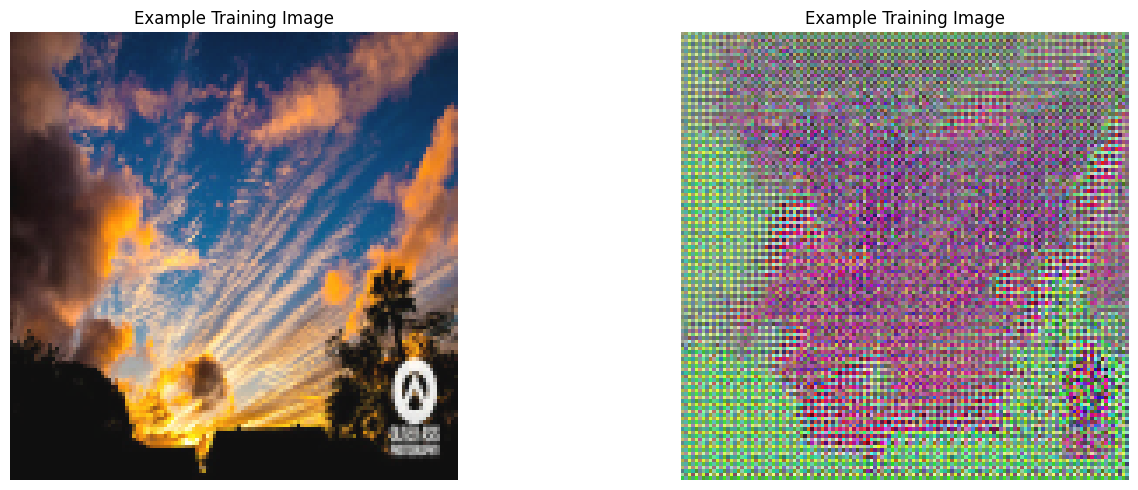

In [33]:
# Plot full training loss curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(to_display(eg_image[0]))  # Normalize the image from [0,255] to [0,1] for display
plt.axis('off')
plt.title('Example Training Image')


plt.subplot(1, 2, 2)
plt.imshow(to_display(eg_output[0]))  # Denormalize the image for display
plt.axis('off')
plt.title('Example Training Image')


plt.tight_layout()
plt.show()


In [34]:
eg_output2 = monet_generator(eg_image)

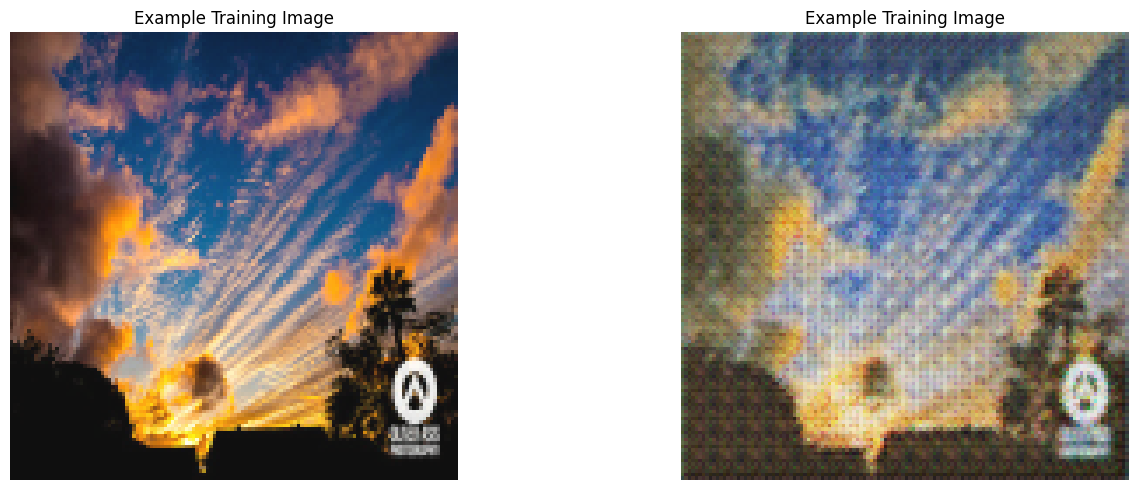

In [35]:
# Plot full training loss curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(to_display(eg_image[0]))  # Normalize the image from [0,255] to [0,1] for display
plt.axis('off')
plt.title('Example Training Image')


plt.subplot(1, 2, 2)
plt.imshow(to_display(eg_output2[0]))  # Denormalize the image for display
plt.axis('off')
plt.title('Example Training Image')


plt.tight_layout()
plt.show()


In [ ]:
# Save the models
monet_generator.save('monet_generator.h5')
photo_generator.save('photo_generator.h5') 
monet_discriminator.save('monet_discriminator.h5')
photo_discriminator.save('photo_discriminator.h5')


In [ ]:
from keras.optimizers import Adam
import numpy as np
import time

NUM_EPOCHS = 3
EPOCH_LENGTH = DATASET_HEIGHT // 3
DISPLAY_INTERVAL = 5  # record loss every 5 steps

my_optimiser = Adam(learning_rate=0.0002, beta_1=0.5)

my_generator = Generator((128, 128, 3), strides=2)
my_discriminator = build_discriminator()

all_losses = []

for i in range(NUM_EPOCHS):
    print(f"\nEpoch {i + 1}/{NUM_EPOCHS}")
    epoch_losses = []
    start_time = time.time()

    for j in range(EPOCH_LENGTH):
        monet_image = (next(my_monet_ds_train)) 
        real_image = (next(my_image_ds_train))

        with tf.GradientTape() as tape:
            monet_output = my_discriminator(monet_image)
            image_output = my_discriminator(real_image)

            loss = 0.5 * (
                my_square_loss(tf.constant(1.0), monet_output) +
                my_square_loss(tf.constant(0.0), image_output)
            )

        grads = tape.gradient(loss, my_discriminator.trainable_variables)
        my_optimiser.apply_gradients(zip(grads, my_discriminator.trainable_variables))

        if j % DISPLAY_INTERVAL == 0:
            epoch_losses.append(tf.squeeze(loss).numpy())
        print(f"\rStep {j + 1}/{EPOCH_LENGTH} - loss: {epoch_losses[-1]:.4f}", end='')

    epoch_avg_loss = np.mean(epoch_losses)
    print(f"\nEpoch {i + 1} completed in {int(time.time() - start_time)}s - avg loss: {epoch_avg_loss:.4f}")
    all_losses.extend(epoch_losses)

# Plot full training loss curve
plt.figure(figsize=(10, 5))
plt.plot(all_losses)
plt.title('Discriminator Loss Over Training')
plt.xlabel(f'Steps (every {DISPLAY_INTERVAL} batches)')
plt.ylabel('Loss')
plt.grid(True)
plt.show()